In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Rescaling, Activation, BatchNormalization

from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.applications import Xception, InceptionV3

2024-01-18 11:22:15.270721: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-18 11:22:15.315181: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 11:22:15.315208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 11:22:15.316205: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-18 11:22:15.323446: I tensorflow/core/platform/cpu_feature_guar

## Dataset Setup

In [2]:
flowers_path = './flowers'

classes = os.listdir(flowers_path)
len(classes)

16

In [3]:
classes

['california_poppy',
 'iris',
 'magnolia',
 'bellflower',
 'astilbe',
 'water_lily',
 'dandelion',
 'sunflower',
 'calendula',
 'common_daisy',
 'tulip',
 'black_eyed_susan',
 'coreopsis',
 'carnation',
 'daffodil',
 'rose']

## Data Preprocessing

#### Passable Parameters

In [4]:
## Passable Parameters

target_size = (150, 150)
input_shape = target_size + (3,)
batch_size = 64


#### Train and Validation image_dataset_from_directory

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    flowers_path,
    validation_split=0.2,          
    subset="training",             
    seed=42,                     
    image_size=target_size,         
    batch_size=batch_size,         
    label_mode="categorical",      
    class_names=classes
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    flowers_path,
    validation_split=0.2,
    subset="validation",         
    seed=42,
    image_size=target_size,
    batch_size=batch_size,
    label_mode="categorical",
    class_names=classes
)

Found 15740 files belonging to 16 classes.
Using 12592 files for training.


2024-01-18 11:22:25.274259: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8980 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


Found 15740 files belonging to 16 classes.
Using 3148 files for validation.


### Image preprocessing by model

#### Xception Preprocessing

In [6]:
# Preprocessing images for xception model
def preprocess_image_xception(image, label):
    image = keras.applications.xception.preprocess_input(image)
    return image, label

In [7]:
# Map preprocessed images to train and val
train_ds = train_ds.map(preprocess_image_xception, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.map(preprocess_image_xception, num_parallel_calls=tf.data.experimental.AUTOTUNE)

#### DenseNet Preprocessing

In [6]:
# Preprocessing for densenset models
def preprocess_image_densenet(image, label):
    image = keras.applications.densenet.preprocess_input(image)
    return image, label

In [7]:
# Map preprocessed images to train and val
train_ds = train_ds.map(preprocess_image_densenet, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.map(preprocess_image_densenet, num_parallel_calls=tf.data.experimental.AUTOTUNE)

#### InceptionV3 Preprocessing

In [106]:
# inception preprocess function
def preprocess_image_inception(image, label):
    image = keras.applications.inception.preprocess_input(image)
    return image, label

In [107]:
# Map preprocessed images to train and val
train_ds = train_ds.map(preprocess_image_inception, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.map(preprocess_image_inception, num_parallel_calls=tf.data.experimental.AUTOTUNE)

### Functions

#### Augmentation Function

In [9]:
def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

#### Results Plotting Function

In [10]:
def show_train_history(train_history,train,validation):
   plt.plot(train_history.history[train])
   plt.plot(train_history.history[validation])
   plt.title('Train History')
   plt.ylabel(train)
   plt.xlabel('Epoch')
   plt.legend(['train', 'validation'], loc='best')
   plt.show()

## Xception Models

#### Basic Model

In [27]:
def get_model():
    # Get base model 
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = Flatten()(base_model.output)
    x = Dense(500, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [28]:
model = get_model()

opt = Adam(learning_rate=0.001, weight_decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
    )
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history_fine=model.fit(train_ds, epochs=20, verbose=1, validation_data=val_ds, callbacks=[checkpoint,early_stopping])

Epoch 1/20
197/197 [==============================] - 14s 56ms/step - loss: 1.5622 - accuracy: 0.6404 - val_loss: 0.8105 - val_accuracy: 0.7392
Epoch 2/20
197/197 [==============================] - 10s 53ms/step - loss: 0.7096 - accuracy: 0.7706 - val_loss: 0.7408 - val_accuracy: 0.7748
Epoch 3/20
197/197 [==============================] - 10s 52ms/step - loss: 0.5515 - accuracy: 0.8203 - val_loss: 0.7093 - val_accuracy: 0.7865
Epoch 4/20
197/197 [==============================] - 10s 50ms/step - loss: 0.4490 - accuracy: 0.8492 - val_loss: 0.6546 - val_accuracy: 0.8005
Epoch 5/20
197/197 [==============================] - 10s 52ms/step - loss: 0.3775 - accuracy: 0.8729 - val_loss: 0.7129 - val_accuracy: 0.8021
Epoch 6/20
197/197 [==============================] - 10s 52ms/step - loss: 0.3365 - accuracy: 0.8835 - val_loss: 0.7162 - val_accuracy: 0.8050
Epoch 7/20
197/197 [==============================] - 10s 52ms/step - loss: 0.2846 - accuracy: 0.8995 - val_loss: 0.7372 - val_accuracy:

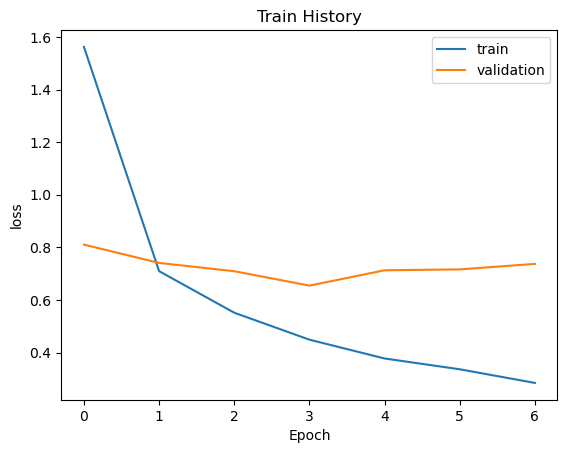

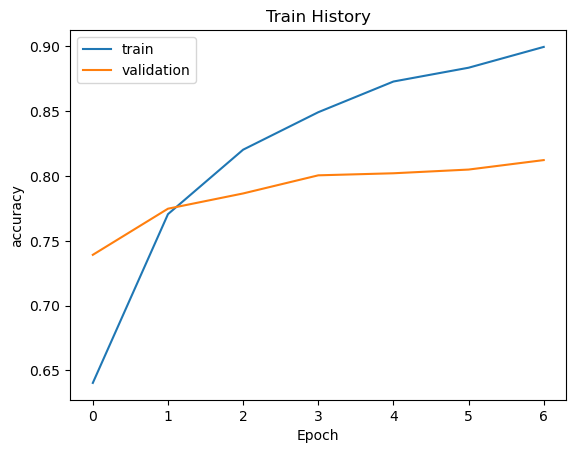

In [29]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### Basic Model with Rescaling(1./255)

In [30]:
def get_model():
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = Rescaling(1./255)
    x = Flatten()(base_model.output)
    x = Dense(500, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model



In [31]:
# Get the model
model = get_model()
# Compile it
opt = Adam(learning_rate=1e-3, weight_decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
    )
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history_fine=model.fit(train_ds, epochs=20, verbose=1, validation_data=val_ds, callbacks=[checkpoint,early_stopping])

Epoch 1/20
197/197 [==============================] - 14s 55ms/step - loss: 1.4737 - accuracy: 0.6475 - val_loss: 0.8155 - val_accuracy: 0.7471
Epoch 2/20
197/197 [==============================] - 10s 52ms/step - loss: 0.7038 - accuracy: 0.7753 - val_loss: 0.7153 - val_accuracy: 0.7789
Epoch 3/20
197/197 [==============================] - 10s 52ms/step - loss: 0.5549 - accuracy: 0.8200 - val_loss: 0.6906 - val_accuracy: 0.7938
Epoch 4/20
197/197 [==============================] - 10s 52ms/step - loss: 0.4567 - accuracy: 0.8463 - val_loss: 0.6478 - val_accuracy: 0.8094
Epoch 5/20
197/197 [==============================] - 9s 45ms/step - loss: 0.3869 - accuracy: 0.8710 - val_loss: 0.6692 - val_accuracy: 0.8078
Epoch 6/20
197/197 [==============================] - 9s 45ms/step - loss: 0.3364 - accuracy: 0.8864 - val_loss: 0.7219 - val_accuracy: 0.8072
Epoch 7/20
197/197 [==============================] - 9s 45ms/step - loss: 0.2838 - accuracy: 0.9020 - val_loss: 0.7326 - val_accuracy: 0.

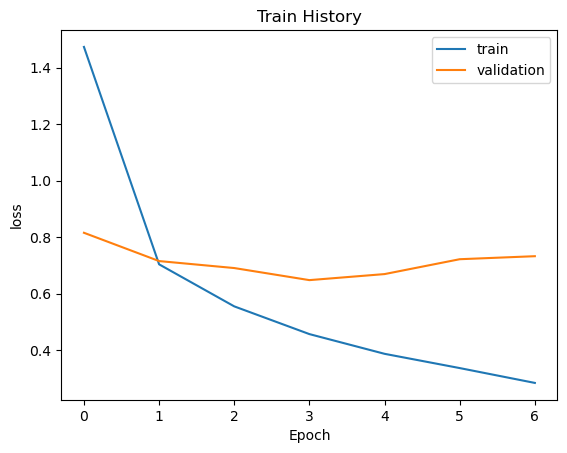

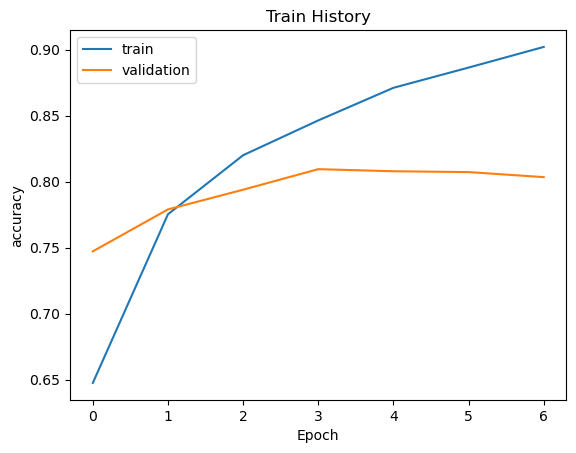

In [32]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### Implementing Augmentation Layers

In [55]:
def get_model():
    # Get base model 
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = Rescaling(1./127.5)
    x = Flatten()(base_model.output)
    x = Dense(500, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [56]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)    
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [57]:
# Get the model
model = get_model()
# Compile it
optimizer = Adam(learning_rate=1e-3, weight_decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=20, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/20
197/197 [==============================] - 68s 329ms/step - loss: 1.7690 - accuracy: 0.5810 - val_loss: 0.8676 - val_accuracy: 0.7220
Epoch 2/20
197/197 [==============================] - 65s 328ms/step - loss: 0.9924 - accuracy: 0.6833 - val_loss: 0.8125 - val_accuracy: 0.7465
Epoch 3/20
197/197 [==============================] - 64s 325ms/step - loss: 0.8970 - accuracy: 0.7124 - val_loss: 0.7972 - val_accuracy: 0.7478
Epoch 4/20
197/197 [==============================] - 64s 327ms/step - loss: 0.8434 - accuracy: 0.7315 - val_loss: 0.7605 - val_accuracy: 0.7694
Epoch 5/20
197/197 [==============================] - 64s 324ms/step - loss: 0.8259 - accuracy: 0.7351 - val_loss: 0.7408 - val_accuracy: 0.7646
Epoch 6/20
197/197 [==============================] - 63s 321ms/step - loss: 0.7695 - accuracy: 0.7559 - val_loss: 0.7641 - val_accuracy: 0.7681
Epoch 7/20
197/197 [==============================] - 65s 329ms/step - loss: 0.7503 - accuracy: 0.7582 - val_loss: 0.7030 - val_ac

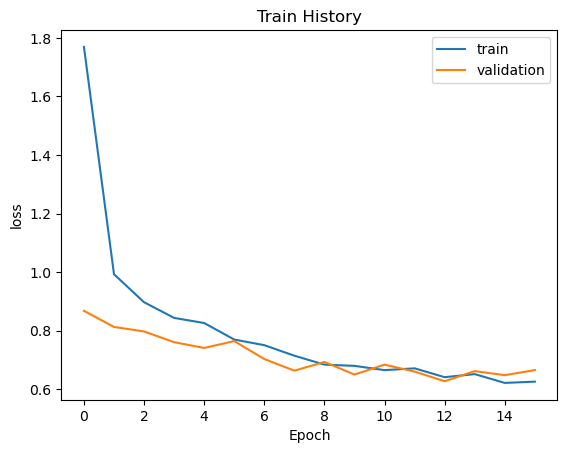

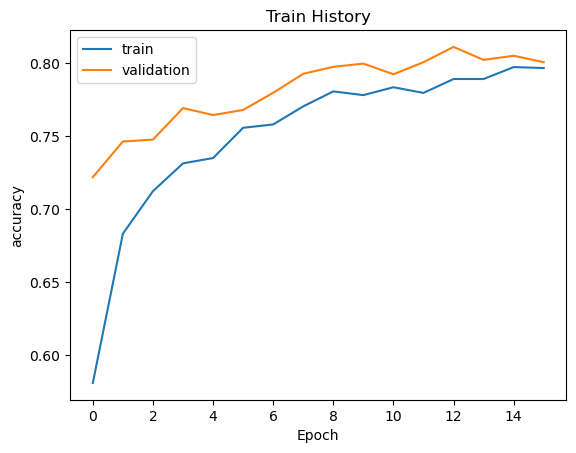

In [58]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

In [59]:
def get_model():
    # Get base model 
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = Rescaling(1./255)
    x = Flatten()(base_model.output)
    x = Dense(500, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [60]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.2),
    # layers.RandomBrightness([-0.2,0.2])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [61]:
# Get the model
model = get_model()
# Compile it
optimizer = Adam(learning_rate=1e-3, weight_decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=20, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/20
197/197 [==============================] - 68s 332ms/step - loss: 1.7906 - accuracy: 0.5717 - val_loss: 0.8417 - val_accuracy: 0.7354
Epoch 2/20
197/197 [==============================] - 64s 324ms/step - loss: 0.9987 - accuracy: 0.6819 - val_loss: 0.9104 - val_accuracy: 0.7198
Epoch 3/20
197/197 [==============================] - 65s 329ms/step - loss: 0.9026 - accuracy: 0.7080 - val_loss: 0.7783 - val_accuracy: 0.7602
Epoch 4/20
197/197 [==============================] - 65s 328ms/step - loss: 0.8631 - accuracy: 0.7255 - val_loss: 0.7455 - val_accuracy: 0.7652
Epoch 5/20
197/197 [==============================] - 64s 326ms/step - loss: 0.8024 - accuracy: 0.7385 - val_loss: 0.7278 - val_accuracy: 0.7751
Epoch 6/20
197/197 [==============================] - 65s 329ms/step - loss: 0.7736 - accuracy: 0.7526 - val_loss: 0.6886 - val_accuracy: 0.7773
Epoch 7/20
197/197 [==============================] - 63s 322ms/step - loss: 0.7337 - accuracy: 0.7665 - val_loss: 0.7538 - val_ac

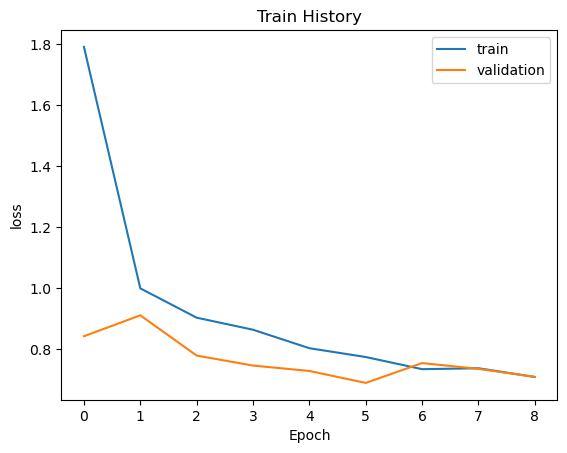

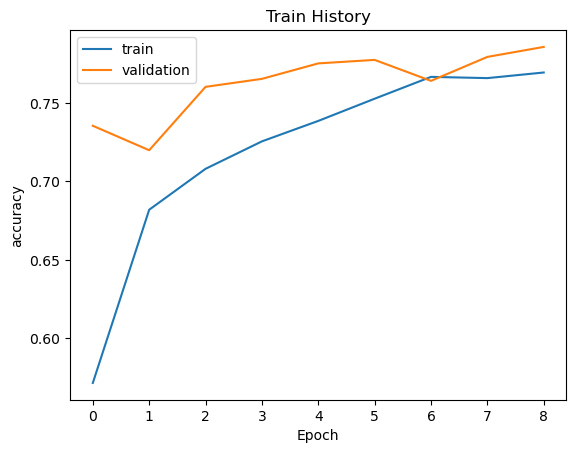

In [62]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### Training with image_size: 256x256 and batch: 32

In [75]:
def get_model():
    # Get base model 
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = Rescaling(1./255)
    x = Flatten()(base_model.output)
    x = Dense(500, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [76]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.2),
    # layers.RandomBrightness([-0.2,0.2])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [77]:
# Get the model
model = get_model()
# Compile it
optimizer = Adam(learning_rate=1e-3, weight_decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=20, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/20
393/394 [============================>.] - ETA: 0s - loss: 1.9620 - accuracy: 0.6299

2024-01-12 14:34:10.160192: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-12 14:34:10.160250: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


394/394 [==============================] - 236s 591ms/step - loss: 1.9603 - accuracy: 0.6302 - val_loss: 0.7172 - val_accuracy: 0.7789
Epoch 2/20
394/394 [==============================] - 231s 585ms/step - loss: 0.9292 - accuracy: 0.7144 - val_loss: 0.5802 - val_accuracy: 0.8212
Epoch 3/20
394/394 [==============================] - 227s 577ms/step - loss: 0.7978 - accuracy: 0.7548 - val_loss: 0.5963 - val_accuracy: 0.8183
Epoch 4/20
394/394 [==============================] - 230s 585ms/step - loss: 0.7232 - accuracy: 0.7757 - val_loss: 0.5173 - val_accuracy: 0.8491
Epoch 5/20
394/394 [==============================] - 231s 585ms/step - loss: 0.7011 - accuracy: 0.7819 - val_loss: 0.4726 - val_accuracy: 0.8574
Epoch 6/20
394/394 [==============================] - 231s 586ms/step - loss: 0.6577 - accuracy: 0.7953 - val_loss: 0.4756 - val_accuracy: 0.8609
Epoch 7/20
394/394 [==============================] - 228s 578ms/step - loss: 0.6213 - accuracy: 0.8057 - val_loss: 0.5049 - val_accura

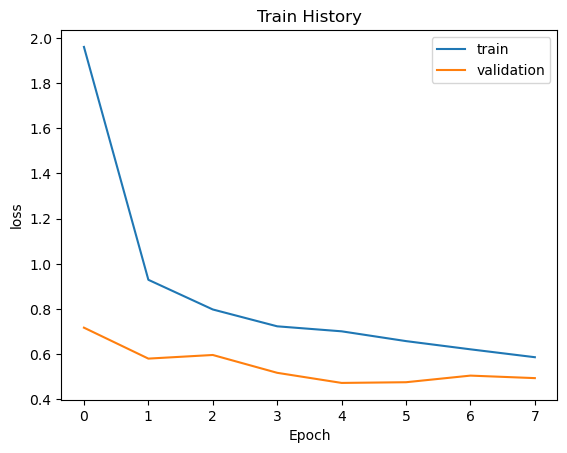

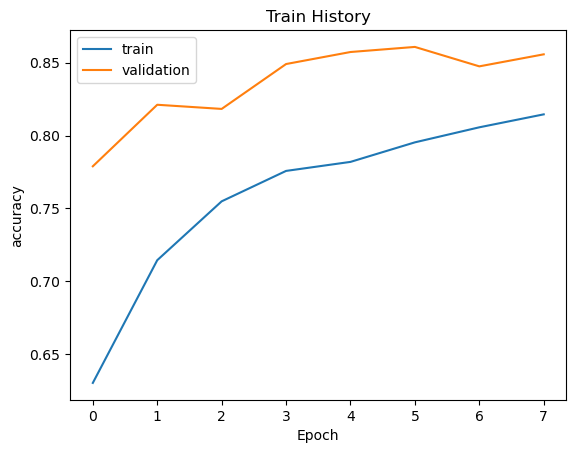

In [78]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### img 256x256 batch 32 scaling 127.5

In [79]:
def get_model():
    # Get base model 
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = Rescaling(1./127.5)
    x = Flatten()(base_model.output)
    x = Dense(500, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [80]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.2),
    # layers.RandomBrightness([-0.2,0.2])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

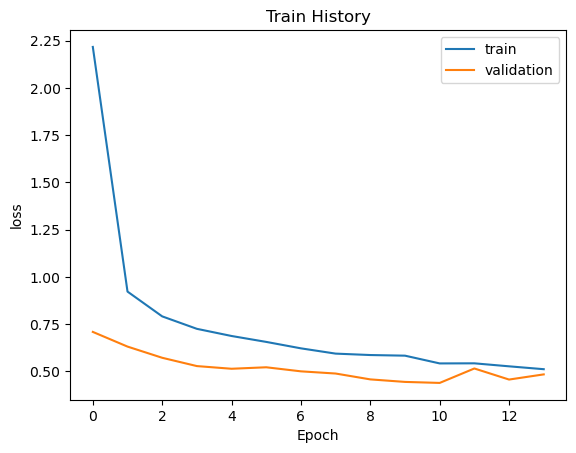

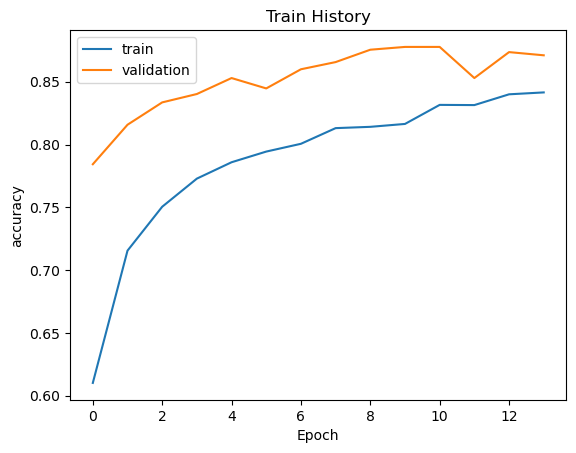

In [82]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### Experimenting with additional changes to layers

In [19]:
def get_model():
    # Get base model 
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = Rescaling(1./255)
    x = Flatten()(base_model.output)
    x = Dense(500, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [20]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.2),
    # layers.RandomBrightness([-0.2,0.2])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [21]:
# Get the model
model = get_model()
# Compile it

# Learning Rate optimizer
scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=20, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/20
394/394 [==============================] - 83s 204ms/step - loss: 1.5921 - accuracy: 0.5695 - val_loss: 0.9118 - val_accuracy: 0.7186
Epoch 2/20
394/394 [==============================] - 80s 203ms/step - loss: 1.0438 - accuracy: 0.6713 - val_loss: 0.9048 - val_accuracy: 0.7208
Epoch 3/20
394/394 [==============================] - 80s 204ms/step - loss: 0.9555 - accuracy: 0.6962 - val_loss: 0.7617 - val_accuracy: 0.7678
Epoch 4/20
394/394 [==============================] - 78s 199ms/step - loss: 0.8566 - accuracy: 0.7256 - val_loss: 0.7542 - val_accuracy: 0.7675
Epoch 5/20
394/394 [==============================] - 80s 202ms/step - loss: 0.8272 - accuracy: 0.7349 - val_loss: 0.7539 - val_accuracy: 0.7767
Epoch 6/20
394/394 [==============================] - 80s 203ms/step - loss: 0.7920 - accuracy: 0.7475 - val_loss: 0.7246 - val_accuracy: 0.7802
Epoch 7/20
394/394 [==============================] - 80s 203ms/step - loss: 0.7525 - accuracy: 0.7558 - val_loss: 0.7004 - val_ac

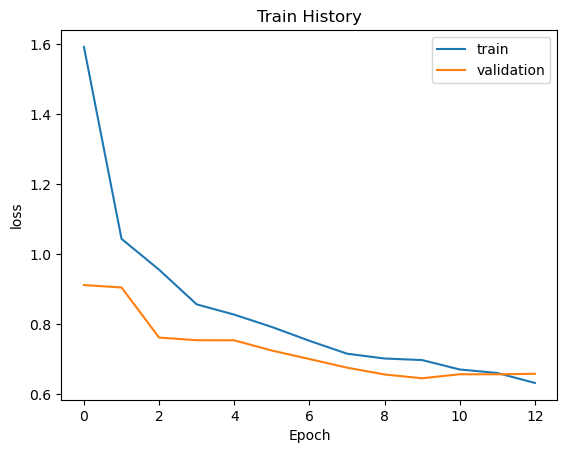

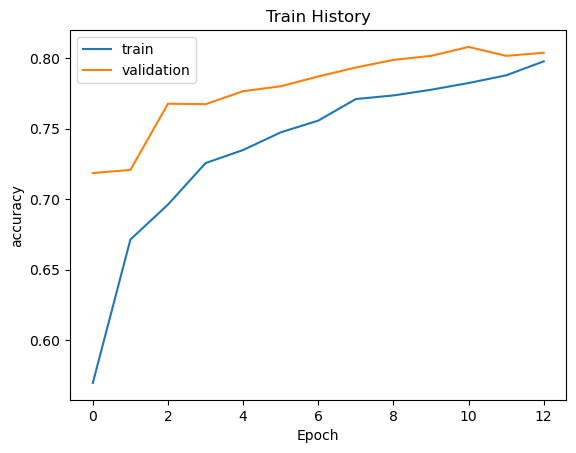

In [24]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### Deeper Network, less nodes (128x128) batch 32

In [13]:
def get_model():
    # Get base model 
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = Rescaling(1./255)
    x = Flatten()(base_model.output)
    x = Dense(16, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [14]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.2),
    # layers.RandomBrightness([-0.2,0.2])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [15]:
# Get the model
model = get_model()
# Compile it

scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=20, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/20


2024-01-15 11:15:47.121278: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-15 11:15:49.072774: I external/local_xla/xla/service/service.cc:168] XLA service 0x75abb8fcf720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-15 11:15:49.072800: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-01-15 11:15:49.085512: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705335349.190661   15068 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


394/394 [==============================] - 87s 205ms/step - loss: 1.9730 - accuracy: 0.3328 - val_loss: 1.5699 - val_accuracy: 0.4533
Epoch 2/20
394/394 [==============================] - 79s 201ms/step - loss: 1.4727 - accuracy: 0.5106 - val_loss: 1.4636 - val_accuracy: 0.5070
Epoch 3/20
394/394 [==============================] - 80s 202ms/step - loss: 1.2929 - accuracy: 0.5677 - val_loss: 1.1910 - val_accuracy: 0.5947
Epoch 4/20
394/394 [==============================] - 80s 202ms/step - loss: 1.1878 - accuracy: 0.6090 - val_loss: 1.1119 - val_accuracy: 0.6258
Epoch 5/20
394/394 [==============================] - 80s 202ms/step - loss: 1.1447 - accuracy: 0.6223 - val_loss: 1.0680 - val_accuracy: 0.6455
Epoch 6/20
394/394 [==============================] - 78s 199ms/step - loss: 1.0961 - accuracy: 0.6412 - val_loss: 1.0795 - val_accuracy: 0.6414
Epoch 7/20
394/394 [==============================] - 79s 200ms/step - loss: 1.0604 - accuracy: 0.6475 - val_loss: 1.0174 - val_accuracy: 0.6

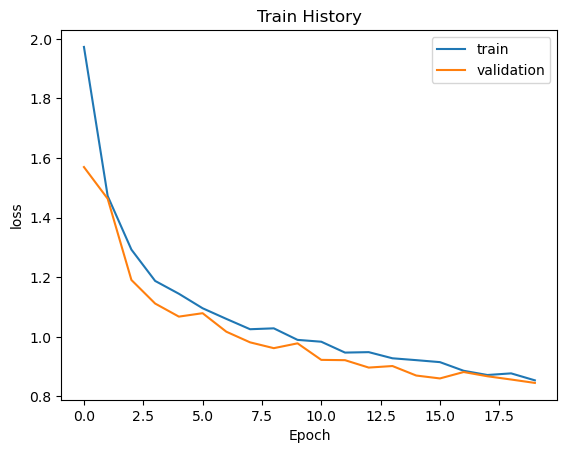

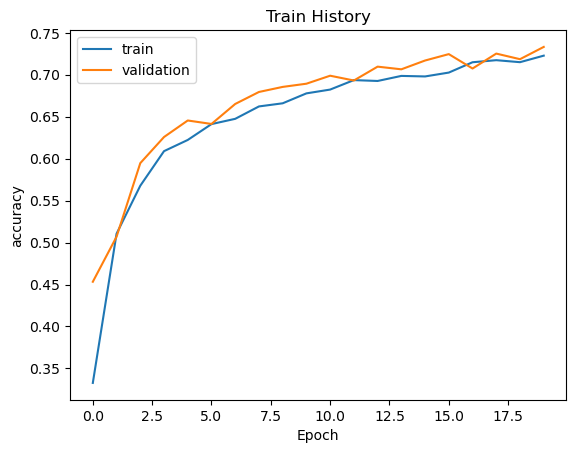

In [18]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### Attempt to keep training previous model

In [20]:
model.load_weights('xception_v1_20_0.733.keras')

scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=20, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/20
394/394 [==============================] - 82s 200ms/step - loss: 0.9139 - accuracy: 0.7074 - val_loss: 0.9083 - val_accuracy: 0.7036
Epoch 2/20
394/394 [==============================] - 80s 202ms/step - loss: 0.9089 - accuracy: 0.7081 - val_loss: 0.9904 - val_accuracy: 0.6900
Epoch 3/20
394/394 [==============================] - 78s 199ms/step - loss: 0.9181 - accuracy: 0.7035 - val_loss: 0.9455 - val_accuracy: 0.7004
Epoch 4/20
303/394 [======================>.......] - ETA: 17s - loss: 0.8914 - accuracy: 0.7151

KeyboardInterrupt: 

#### Similar to above, batch size 64

In [26]:
def get_model():
    # Get base model 
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = Rescaling(1./255)
    x = Flatten()(base_model.output)
    x = Dense(16, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [27]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.2),
    # layers.RandomBrightness([-0.2,0.2])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [28]:
# Get the model
model = get_model()
# Compile it

scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#Summary
# model.summary()
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/30
197/197 [==============================] - 70s 334ms/step - loss: 1.8103 - accuracy: 0.4135 - val_loss: 1.3073 - val_accuracy: 0.5762
Epoch 2/30
197/197 [==============================] - 64s 324ms/step - loss: 1.2334 - accuracy: 0.6041 - val_loss: 1.0623 - val_accuracy: 0.6639
Epoch 3/30
197/197 [==============================] - 65s 328ms/step - loss: 1.1188 - accuracy: 0.6369 - val_loss: 1.0488 - val_accuracy: 0.6684
Epoch 4/30
197/197 [==============================] - 63s 320ms/step - loss: 1.0380 - accuracy: 0.6642 - val_loss: 1.0863 - val_accuracy: 0.6560
Epoch 5/30
197/197 [==============================] - 64s 326ms/step - loss: 0.9890 - accuracy: 0.6771 - val_loss: 0.9507 - val_accuracy: 0.6871
Epoch 6/30
197/197 [==============================] - 65s 327ms/step - loss: 0.9459 - accuracy: 0.6946 - val_loss: 0.9156 - val_accuracy: 0.7125
Epoch 7/30
197/197 [==============================] - 64s 326ms/step - loss: 0.9096 - accuracy: 0.7051 - val_loss: 0.8688 - val_ac

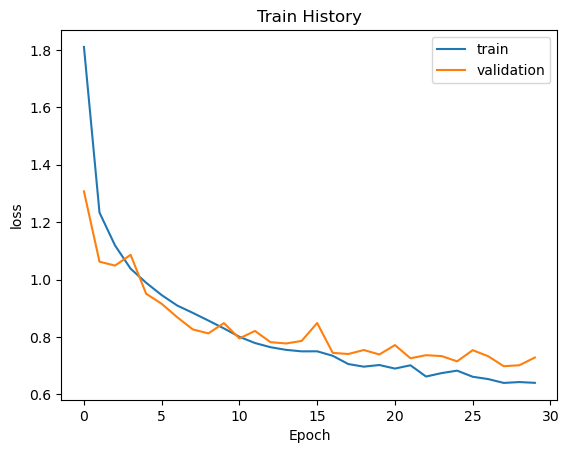

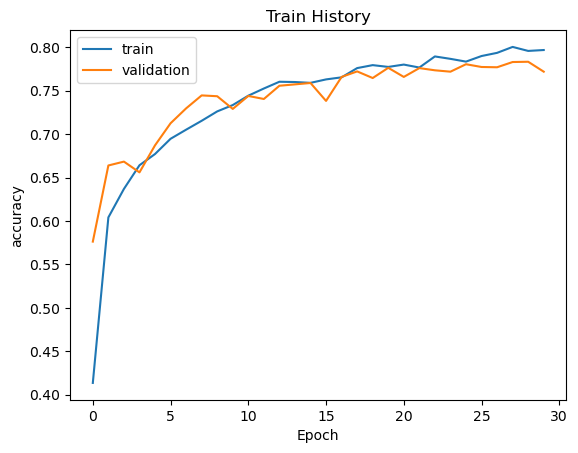

In [29]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### Resolution 256x256 Batch 32

In [34]:
def get_model():
    # Get base model 
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = Rescaling(1./255)
    x = Flatten()(base_model.output)
    x = Dense(16, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [35]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.2),
    # layers.RandomBrightness([-0.2,0.2])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [36]:
# Get the model
model = get_model()
# Compile it

scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#Summary
# model.summary()
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v3_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/30
394/394 [==============================] - 236s 585ms/step - loss: 2.4598 - accuracy: 0.1456 - val_loss: 2.0327 - val_accuracy: 0.2052
Epoch 2/30
394/394 [==============================] - 229s 581ms/step - loss: 1.9286 - accuracy: 0.2712 - val_loss: 1.7555 - val_accuracy: 0.3088
Epoch 3/30
394/394 [==============================] - 229s 581ms/step - loss: 1.7066 - accuracy: 0.3579 - val_loss: 1.4685 - val_accuracy: 0.4476
Epoch 4/30
394/394 [==============================] - 228s 578ms/step - loss: 1.5033 - accuracy: 0.4373 - val_loss: 1.4675 - val_accuracy: 0.4489
Epoch 5/30
394/394 [==============================] - 228s 580ms/step - loss: 1.3682 - accuracy: 0.4810 - val_loss: 1.2866 - val_accuracy: 0.5060
Epoch 6/30
394/394 [==============================] - 228s 577ms/step - loss: 1.2588 - accuracy: 0.5416 - val_loss: 1.1844 - val_accuracy: 0.5747
Epoch 7/30
394/394 [==============================] - 227s 577ms/step - loss: 1.1321 - accuracy: 0.6046 - val_loss: 1.0305 -

#### 128x128 batch: 128

In [54]:
def get_model():
    # Get base model 
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = Rescaling(1./255)
    x = Flatten()(base_model.output)
    x = Dense(16, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [55]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.2),
    # layers.RandomBrightness([-0.2,0.2])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [56]:
# Get the model
model = get_model()
# Compile it

scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v3_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/30
99/99 [==============================] - 64s 598ms/step - loss: 1.8183 - accuracy: 0.4121 - val_loss: 1.1583 - val_accuracy: 0.6312
Epoch 2/30
99/99 [==============================] - 57s 574ms/step - loss: 1.2012 - accuracy: 0.6123 - val_loss: 0.9676 - val_accuracy: 0.6941
Epoch 3/30
99/99 [==============================] - 57s 574ms/step - loss: 1.0393 - accuracy: 0.6751 - val_loss: 0.9094 - val_accuracy: 0.7166
Epoch 4/30
99/99 [==============================] - 57s 578ms/step - loss: 0.9527 - accuracy: 0.7010 - val_loss: 0.8308 - val_accuracy: 0.7459
Epoch 5/30
99/99 [==============================] - 57s 573ms/step - loss: 0.8942 - accuracy: 0.7182 - val_loss: 0.7991 - val_accuracy: 0.7525
Epoch 6/30
99/99 [==============================] - 57s 576ms/step - loss: 0.8658 - accuracy: 0.7259 - val_loss: 0.7861 - val_accuracy: 0.7621
Epoch 7/30
99/99 [==============================] - 56s 567ms/step - loss: 0.8212 - accuracy: 0.7404 - val_loss: 0.7962 - val_accuracy: 0.7510

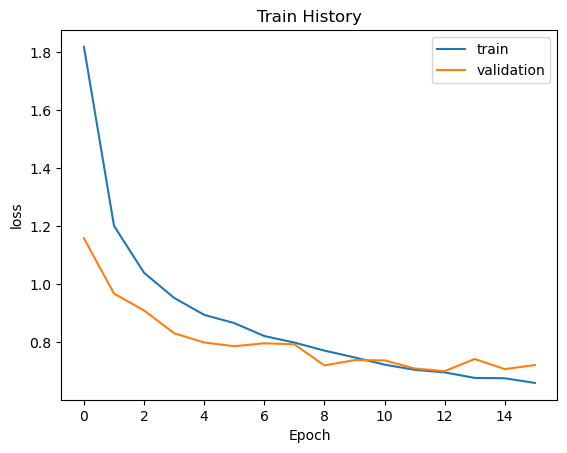

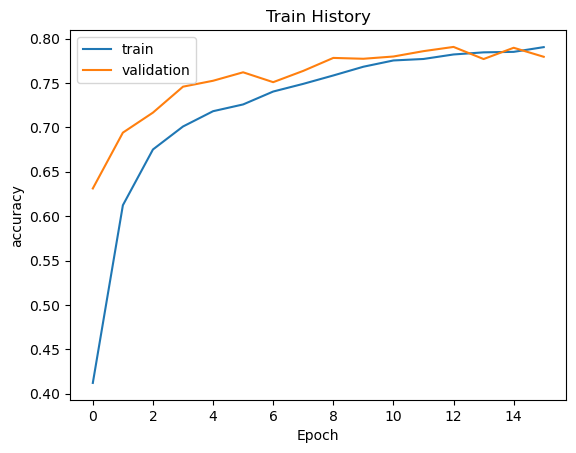

In [57]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### Add more layers, keep 128x128 batch 128

In [59]:
def get_model():
    # Get base model 
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = Rescaling(1./255)
    x = Flatten()(base_model.output)
    x = Dense(16, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [60]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.2),
    # layers.RandomBrightness([-0.2,0.2])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [61]:
# Get the model
model = get_model()
# Compile it

scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v3_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/30
99/99 [==============================] - 62s 584ms/step - loss: 1.7201 - accuracy: 0.4448 - val_loss: 1.0844 - val_accuracy: 0.6607
Epoch 2/30
99/99 [==============================] - 57s 578ms/step - loss: 1.1275 - accuracy: 0.6364 - val_loss: 1.0457 - val_accuracy: 0.6766
Epoch 3/30
99/99 [==============================] - 57s 578ms/step - loss: 0.9879 - accuracy: 0.6861 - val_loss: 0.9140 - val_accuracy: 0.7166
Epoch 4/30
99/99 [==============================] - 57s 573ms/step - loss: 0.9065 - accuracy: 0.7106 - val_loss: 0.8067 - val_accuracy: 0.7544
Epoch 5/30
99/99 [==============================] - 57s 577ms/step - loss: 0.8474 - accuracy: 0.7321 - val_loss: 0.8128 - val_accuracy: 0.7567
Epoch 6/30
99/99 [==============================] - 57s 577ms/step - loss: 0.8194 - accuracy: 0.7395 - val_loss: 0.7943 - val_accuracy: 0.7602
Epoch 7/30
99/99 [==============================] - 57s 572ms/step - loss: 0.7911 - accuracy: 0.7484 - val_loss: 0.7961 - val_accuracy: 0.7535

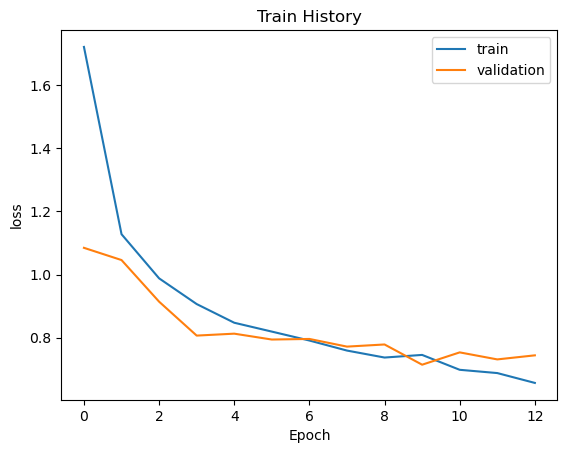

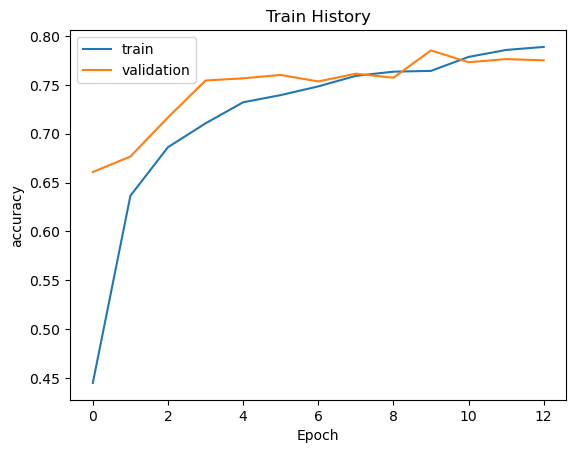

In [62]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### Same as above with additional dense layer

In [63]:
def get_model():
    # Get base model 
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = Rescaling(1./255)
    x = Flatten()(base_model.output)
    x = Dense(16, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [64]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.2),
    # layers.RandomBrightness([-0.2,0.2])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [65]:
# Get the model
model = get_model()
# Compile it

scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v3_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/30
99/99 [==============================] - 62s 580ms/step - loss: 1.7005 - accuracy: 0.4374 - val_loss: 1.0660 - val_accuracy: 0.6449
Epoch 2/30
99/99 [==============================] - 57s 574ms/step - loss: 1.1287 - accuracy: 0.6309 - val_loss: 0.9929 - val_accuracy: 0.6868
Epoch 3/30
99/99 [==============================] - 56s 566ms/step - loss: 0.9908 - accuracy: 0.6797 - val_loss: 1.0462 - val_accuracy: 0.6728
Epoch 4/30
99/99 [==============================] - 57s 572ms/step - loss: 0.9147 - accuracy: 0.7114 - val_loss: 0.9144 - val_accuracy: 0.7062
Epoch 5/30
99/99 [==============================] - 57s 573ms/step - loss: 0.8545 - accuracy: 0.7321 - val_loss: 0.8002 - val_accuracy: 0.7554
Epoch 6/30
99/99 [==============================] - 57s 578ms/step - loss: 0.8222 - accuracy: 0.7438 - val_loss: 0.7487 - val_accuracy: 0.7659
Epoch 7/30
99/99 [==============================] - 57s 570ms/step - loss: 0.7916 - accuracy: 0.7497 - val_loss: 0.7735 - val_accuracy: 0.7551

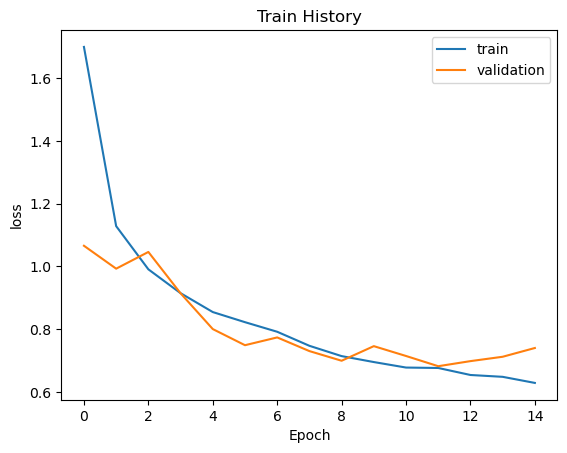

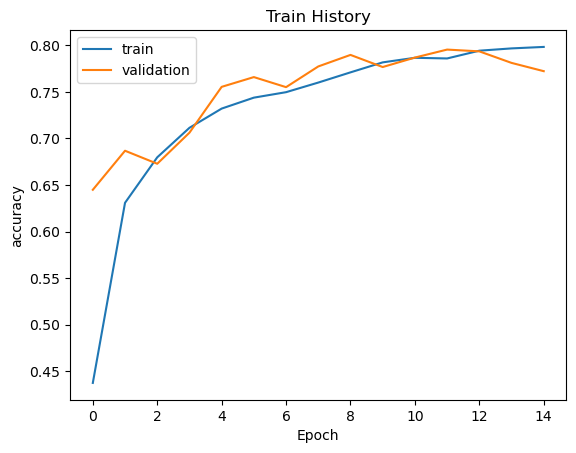

In [66]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### Simplify Layers

In [67]:
def get_model():
    # Get base model 
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = Rescaling(1./255)
    x = Flatten()(base_model.output)
    x = Dense(16, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [68]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.2),
    # layers.RandomBrightness([-0.2,0.2])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [69]:
# Get the model
model = get_model()
# Compile it

scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v3_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/30
99/99 [==============================] - 61s 580ms/step - loss: 2.1197 - accuracy: 0.2850 - val_loss: 1.5108 - val_accuracy: 0.4876
Epoch 2/30
99/99 [==============================] - 57s 576ms/step - loss: 1.4978 - accuracy: 0.5024 - val_loss: 1.2659 - val_accuracy: 0.5924
Epoch 3/30
99/99 [==============================] - 57s 572ms/step - loss: 1.2351 - accuracy: 0.6019 - val_loss: 1.0288 - val_accuracy: 0.6782
Epoch 4/30
99/99 [==============================] - 57s 577ms/step - loss: 1.1037 - accuracy: 0.6571 - val_loss: 0.9923 - val_accuracy: 0.6992
Epoch 5/30
99/99 [==============================] - 57s 575ms/step - loss: 1.0355 - accuracy: 0.6750 - val_loss: 0.9292 - val_accuracy: 0.7135
Epoch 6/30
99/99 [==============================] - 57s 578ms/step - loss: 0.9605 - accuracy: 0.7044 - val_loss: 0.9476 - val_accuracy: 0.7147
Epoch 7/30
99/99 [==============================] - 57s 570ms/step - loss: 0.9195 - accuracy: 0.7179 - val_loss: 0.9842 - val_accuracy: 0.6960

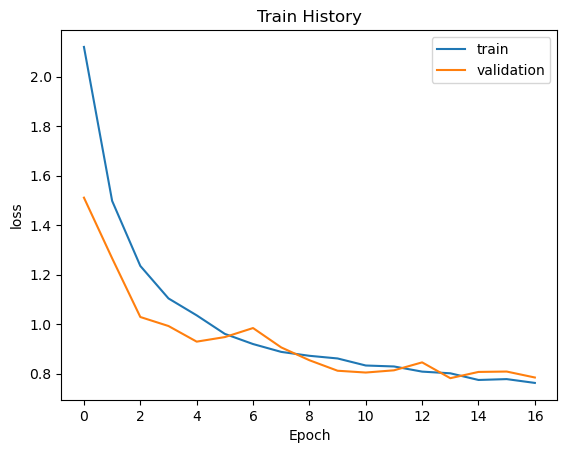

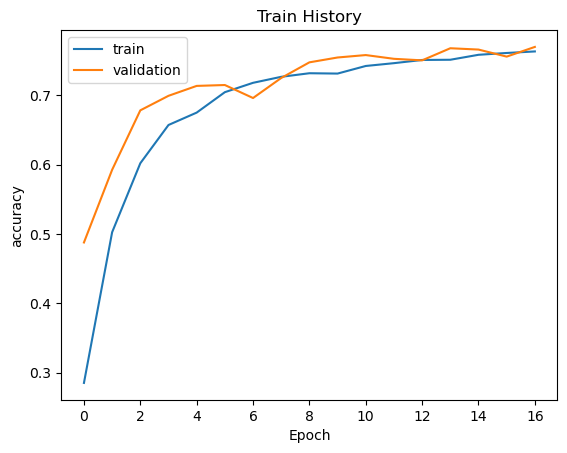

In [70]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### Keep only widest dense layers

In [72]:
def get_model():
    # Get base model 
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = Rescaling(1./255)
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [73]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.2),
    # layers.RandomBrightness([-0.2,0.2])
]

train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [74]:
# Get the model
model = get_model()
# Compile it

scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v3_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/30
99/99 [==============================] - 61s 583ms/step - loss: 1.5584 - accuracy: 0.5507 - val_loss: 0.8503 - val_accuracy: 0.7382
Epoch 2/30
99/99 [==============================] - 57s 579ms/step - loss: 0.9358 - accuracy: 0.7045 - val_loss: 0.7839 - val_accuracy: 0.7548
Epoch 3/30
99/99 [==============================] - 57s 577ms/step - loss: 0.8406 - accuracy: 0.7366 - val_loss: 0.7400 - val_accuracy: 0.7741
Epoch 4/30
99/99 [==============================] - 57s 571ms/step - loss: 0.7566 - accuracy: 0.7610 - val_loss: 0.7286 - val_accuracy: 0.7840
Epoch 5/30
99/99 [==============================] - 56s 570ms/step - loss: 0.7107 - accuracy: 0.7739 - val_loss: 0.8084 - val_accuracy: 0.7605
Epoch 6/30
99/99 [==============================] - 58s 580ms/step - loss: 0.6964 - accuracy: 0.7817 - val_loss: 0.6847 - val_accuracy: 0.7948
Epoch 7/30
99/99 [==============================] - 57s 579ms/step - loss: 0.6452 - accuracy: 0.7927 - val_loss: 0.6616 - val_accuracy: 0.7954

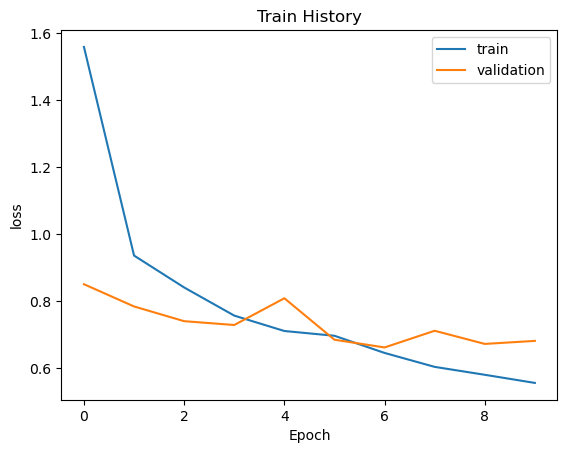

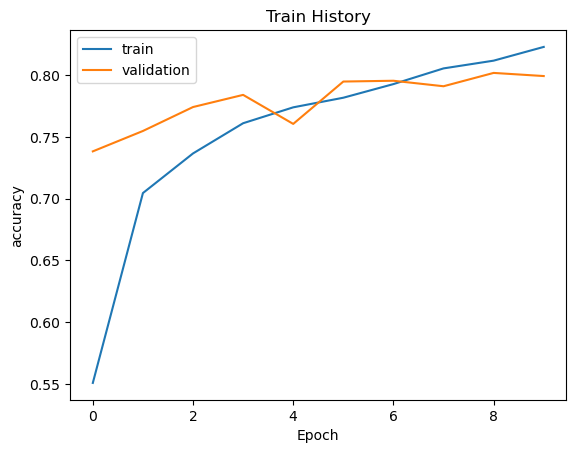

In [75]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### Same as above, but with 150x150 image batch=64

In [119]:
def get_model():
    # Get base model 
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = Rescaling(1./255)
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [120]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.2),
    # layers.RandomBrightness([-0.2,0.2])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [121]:
# Get the model
model = get_model()
# Compile it

scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v3_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/30
197/197 [==============================] - 90s 433ms/step - loss: 1.4568 - accuracy: 0.6071 - val_loss: 0.8699 - val_accuracy: 0.7278
Epoch 2/30
197/197 [==============================] - 84s 425ms/step - loss: 0.9135 - accuracy: 0.7225 - val_loss: 0.7736 - val_accuracy: 0.7716
Epoch 3/30
197/197 [==============================] - 83s 423ms/step - loss: 0.7592 - accuracy: 0.7659 - val_loss: 0.7163 - val_accuracy: 0.7957
Epoch 4/30
197/197 [==============================] - 83s 419ms/step - loss: 0.7021 - accuracy: 0.7825 - val_loss: 0.6823 - val_accuracy: 0.7948
Epoch 5/30
197/197 [==============================] - 83s 423ms/step - loss: 0.6482 - accuracy: 0.7997 - val_loss: 0.6485 - val_accuracy: 0.8072
Epoch 6/30
197/197 [==============================] - 83s 419ms/step - loss: 0.6018 - accuracy: 0.8102 - val_loss: 0.7069 - val_accuracy: 0.7961
Epoch 7/30
197/197 [==============================] - 84s 424ms/step - loss: 0.5689 - accuracy: 0.8258 - val_loss: 0.6332 - val_ac

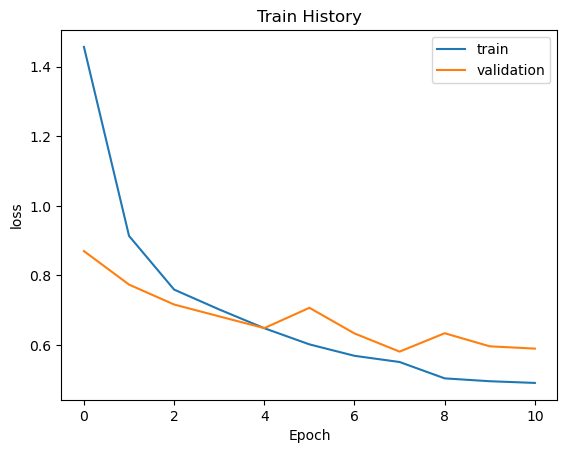

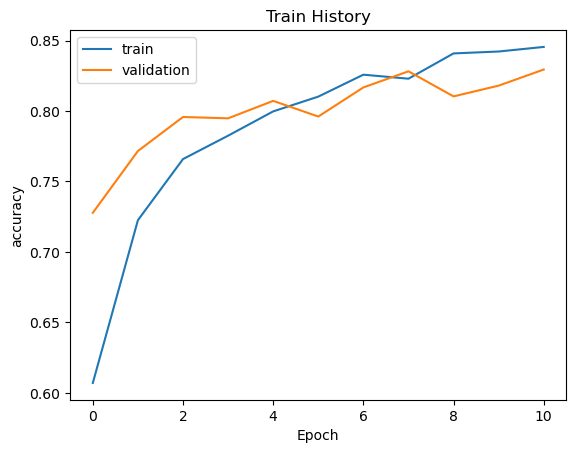

In [122]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### Same as above (150x150) batch=64 with modifications to augmentation

In [124]:
def get_model():
    # Get base model 
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = Rescaling(1./255)
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [127]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    # layers.RandomContrast(0.2),
    # layers.RandomBrightness([-0.2,0.2])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [128]:
# Get the model
model = get_model()
# Compile it

scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#Summary
# model.summary()
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v3_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/30
197/197 [==============================] - 87s 428ms/step - loss: 1.6152 - accuracy: 0.5695 - val_loss: 0.8612 - val_accuracy: 0.7328
Epoch 2/30
197/197 [==============================] - 84s 425ms/step - loss: 0.9543 - accuracy: 0.7049 - val_loss: 0.7708 - val_accuracy: 0.7595
Epoch 3/30
197/197 [==============================] - 84s 424ms/step - loss: 0.8479 - accuracy: 0.7435 - val_loss: 0.7179 - val_accuracy: 0.7814
Epoch 4/30
197/197 [==============================] - 83s 419ms/step - loss: 0.7819 - accuracy: 0.7595 - val_loss: 0.7816 - val_accuracy: 0.7646
Epoch 5/30
197/197 [==============================] - 84s 425ms/step - loss: 0.7481 - accuracy: 0.7674 - val_loss: 0.7193 - val_accuracy: 0.7834
Epoch 6/30
197/197 [==============================] - 83s 424ms/step - loss: 0.7033 - accuracy: 0.7822 - val_loss: 0.6475 - val_accuracy: 0.8008
Epoch 7/30
197/197 [==============================] - 84s 428ms/step - loss: 0.6511 - accuracy: 0.7977 - val_loss: 0.5928 - val_ac

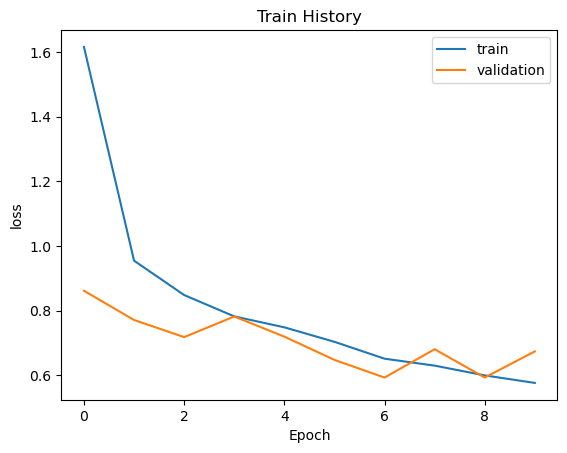

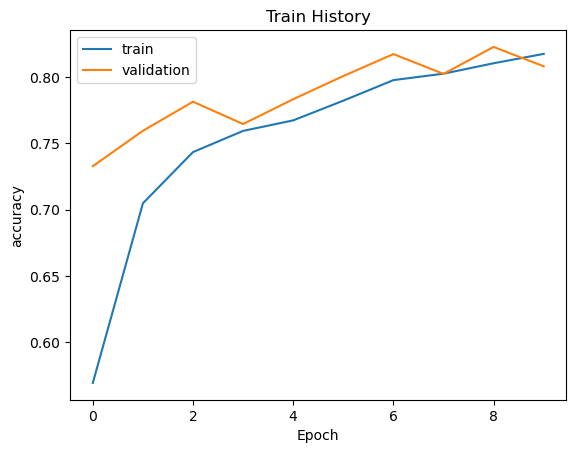

In [129]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### Same as above (150x150) batch=64 with modifications to augmentation 0.1

In [10]:
def get_model():
    # Get base model 
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = Rescaling(1./255)
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [11]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    # layers.RandomContrast(0.2),
    # layers.RandomBrightness([-0.2,0.2])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [12]:
# Get the model
model = get_model()
# Compile it

scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#Summary
# model.summary()
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v3_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/30


2024-01-16 11:06:48.545661: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-16 11:06:51.100772: I external/local_xla/xla/service/service.cc:168] XLA service 0x7dee21168730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-16 11:06:51.100800: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-01-16 11:06:51.114706: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705421211.228520   17189 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


197/197 [==============================] - 91s 430ms/step - loss: 1.3619 - accuracy: 0.6286 - val_loss: 0.8159 - val_accuracy: 0.7529
Epoch 2/30
197/197 [==============================] - 83s 421ms/step - loss: 0.7905 - accuracy: 0.7538 - val_loss: 0.6909 - val_accuracy: 0.8021
Epoch 3/30
197/197 [==============================] - 81s 412ms/step - loss: 0.6880 - accuracy: 0.7888 - val_loss: 0.7376 - val_accuracy: 0.7891
Epoch 4/30
197/197 [==============================] - 83s 420ms/step - loss: 0.5962 - accuracy: 0.8151 - val_loss: 0.6536 - val_accuracy: 0.8088
Epoch 5/30
197/197 [==============================] - 83s 423ms/step - loss: 0.5242 - accuracy: 0.8371 - val_loss: 0.5720 - val_accuracy: 0.8358
Epoch 6/30
197/197 [==============================] - 82s 415ms/step - loss: 0.4926 - accuracy: 0.8444 - val_loss: 0.6072 - val_accuracy: 0.8243
Epoch 7/30
197/197 [==============================] - 82s 416ms/step - loss: 0.4381 - accuracy: 0.8609 - val_loss: 0.6058 - val_accuracy: 0.8

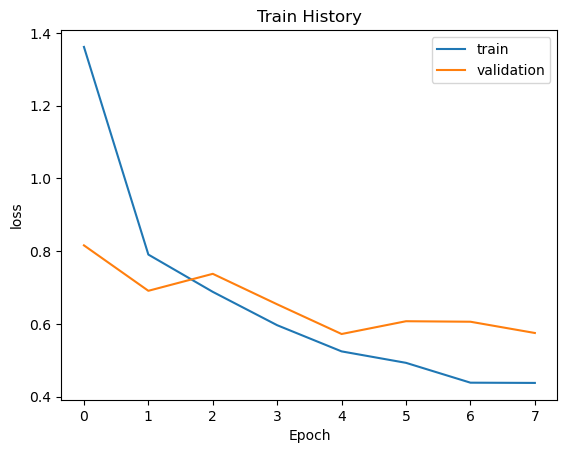

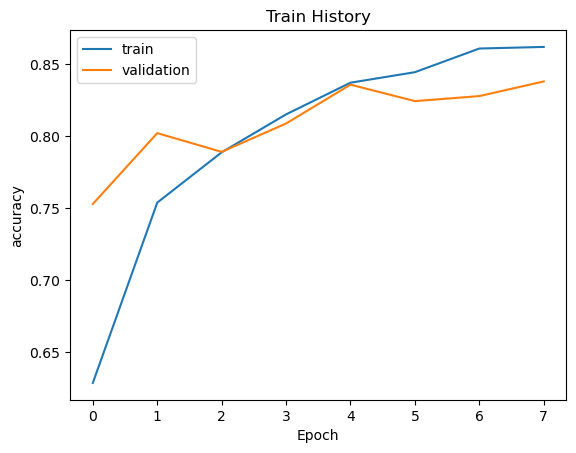

In [13]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### Same as above (150x150) batch=64 with modifications to augmentation 0.1 add contrast/brightness

In [25]:
def get_model():
    # Get base model 
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = Rescaling(1./255)
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [26]:
augmentation_layers = [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    # layers.RandomContrast(0.1),
    # layers.RandomBrightness([-0.1,0.1])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [27]:
# Get the model
model = get_model()
# Compile it

scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#Summary
# model.summary()
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v3_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/30
197/197 [==============================] - 87s 428ms/step - loss: 1.4434 - accuracy: 0.5939 - val_loss: 0.8437 - val_accuracy: 0.7446
Epoch 2/30
197/197 [==============================] - 83s 423ms/step - loss: 0.9411 - accuracy: 0.7108 - val_loss: 0.7644 - val_accuracy: 0.7691
Epoch 3/30
197/197 [==============================] - 83s 423ms/step - loss: 0.7801 - accuracy: 0.7637 - val_loss: 0.7291 - val_accuracy: 0.7808
Epoch 4/30
197/197 [==============================] - 84s 427ms/step - loss: 0.7188 - accuracy: 0.7812 - val_loss: 0.7437 - val_accuracy: 0.7872
Epoch 5/30
197/197 [==============================] - 83s 423ms/step - loss: 0.6478 - accuracy: 0.8004 - val_loss: 0.6648 - val_accuracy: 0.8034
Epoch 6/30
197/197 [==============================] - 84s 425ms/step - loss: 0.6009 - accuracy: 0.8115 - val_loss: 0.6246 - val_accuracy: 0.8107
Epoch 7/30
197/197 [==============================] - 82s 418ms/step - loss: 0.5723 - accuracy: 0.8187 - val_loss: 0.6855 - val_ac

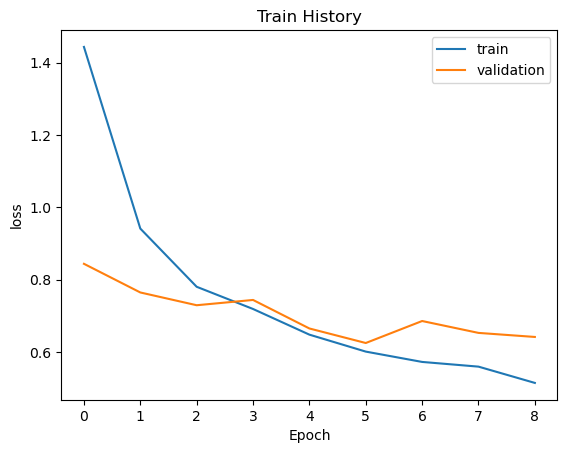

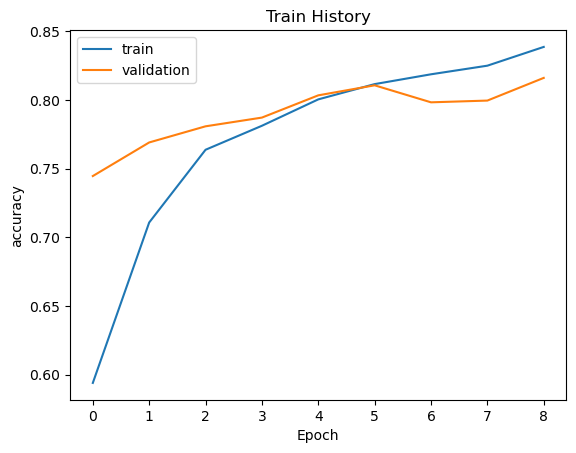

In [28]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### 150x150 batch=64 modify learning rate optimizer

In [29]:
def get_model():
    # Get base model 
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = Rescaling(1./255)
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [30]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    # layers.RandomContrast(0.1),
    # layers.RandomBrightness([-0.1,0.1])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [34]:
# Get the model
model = get_model()
# Compile it

scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.75,
    staircase=True
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#Summary
# model.summary()
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v3_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/30
197/197 [==============================] - 86s 423ms/step - loss: 1.3416 - accuracy: 0.6271 - val_loss: 0.8695 - val_accuracy: 0.7424
Epoch 2/30
197/197 [==============================] - 83s 421ms/step - loss: 0.8063 - accuracy: 0.7499 - val_loss: 0.6838 - val_accuracy: 0.7875
Epoch 3/30
197/197 [==============================] - 83s 420ms/step - loss: 0.6802 - accuracy: 0.7901 - val_loss: 0.6537 - val_accuracy: 0.8002
Epoch 4/30
197/197 [==============================] - 83s 420ms/step - loss: 0.6080 - accuracy: 0.8095 - val_loss: 0.6592 - val_accuracy: 0.8081
Epoch 5/30
197/197 [==============================] - 83s 419ms/step - loss: 0.5617 - accuracy: 0.8241 - val_loss: 0.6275 - val_accuracy: 0.8145
Epoch 6/30
197/197 [==============================] - 82s 414ms/step - loss: 0.5216 - accuracy: 0.8334 - val_loss: 0.6439 - val_accuracy: 0.8142
Epoch 7/30
197/197 [==============================] - 82s 417ms/step - loss: 0.4705 - accuracy: 0.8518 - val_loss: 0.6508 - val_ac

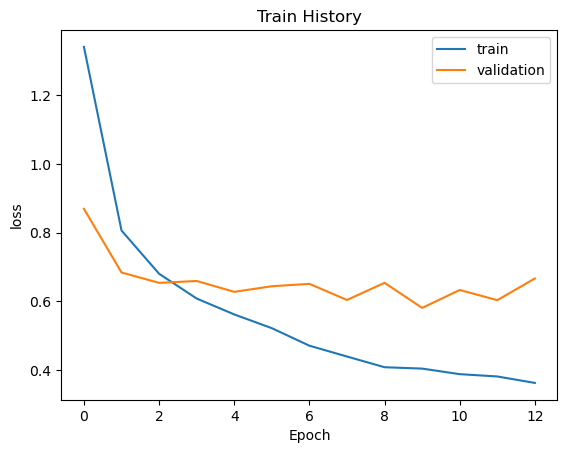

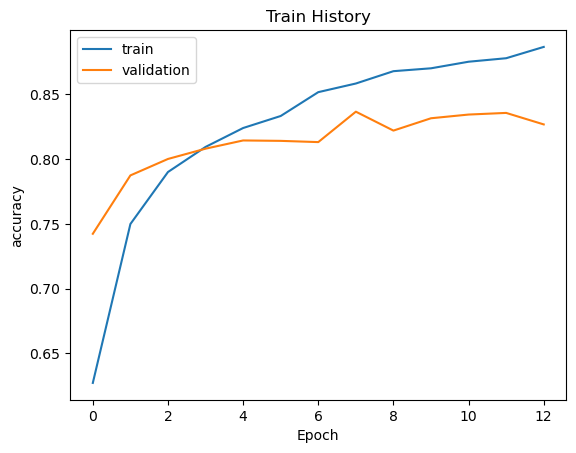

In [35]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### 150x150 batch=64 layers modifications with adjustments to converge fix overfitting below

In [100]:
def get_model():
    # Get base model 
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = layers.Rescaling(1./255)(base_model.output)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [101]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.1),
    # layers.RandomBrightness([-0.1,0.1])
]

train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [102]:
# Get the model
model = get_model()
# Compile it

scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.90,
    staircase=True
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#Summary
# model.summary()
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v3_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/30
197/197 [==============================] - 87s 428ms/step - loss: 2.3128 - accuracy: 0.4217 - val_loss: 1.6974 - val_accuracy: 0.5966
Epoch 2/30
197/197 [==============================] - 84s 427ms/step - loss: 1.5445 - accuracy: 0.5847 - val_loss: 1.1765 - val_accuracy: 0.6811
Epoch 3/30
197/197 [==============================] - 84s 424ms/step - loss: 1.2385 - accuracy: 0.6356 - val_loss: 0.9868 - val_accuracy: 0.7157
Epoch 4/30
197/197 [==============================] - 84s 425ms/step - loss: 1.0836 - accuracy: 0.6747 - val_loss: 0.8829 - val_accuracy: 0.7379
Epoch 5/30
197/197 [==============================] - 84s 426ms/step - loss: 0.9942 - accuracy: 0.6981 - val_loss: 0.8224 - val_accuracy: 0.7519
Epoch 6/30
197/197 [==============================] - 84s 428ms/step - loss: 0.9325 - accuracy: 0.7131 - val_loss: 0.7760 - val_accuracy: 0.7665
Epoch 7/30
197/197 [==============================] - 84s 427ms/step - loss: 0.8728 - accuracy: 0.7304 - val_loss: 0.7327 - val_ac

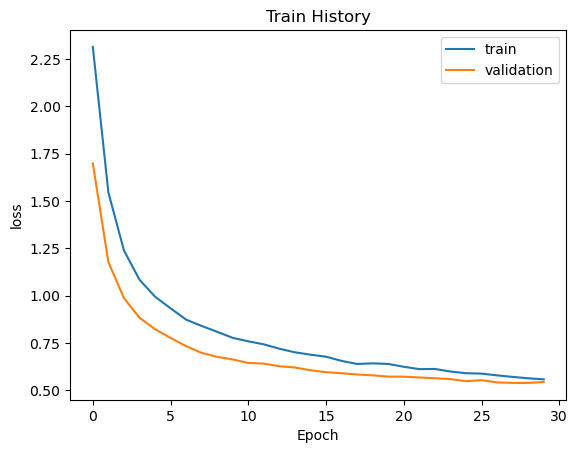

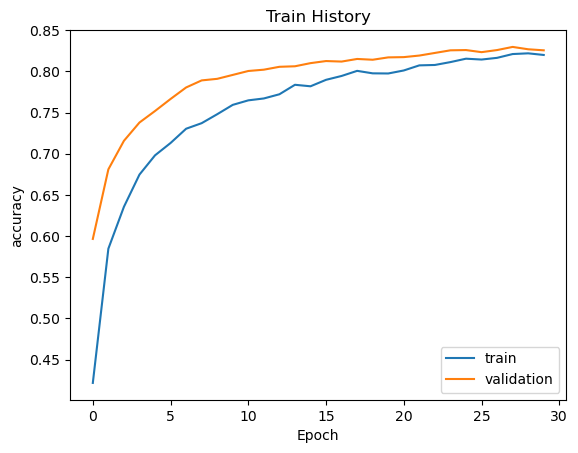

In [103]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### 150x150 batch=64 layers modifications with adjustments to converge

In [96]:
def get_model():
    # Get base model 
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = layers.Rescaling(1./255)(base_model.output)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [97]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.1),
    # layers.RandomBrightness([-0.1,0.1])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [98]:
# Get the model
model = get_model()
# Compile it

scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-4,
    decay_steps=1000,
    decay_rate=0.90,
    staircase=True
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#Summary
# model.summary()
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v3_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/30
197/197 [==============================] - 88s 431ms/step - loss: 1.6004 - accuracy: 0.5417 - val_loss: 0.9098 - val_accuracy: 0.7249
Epoch 2/30
197/197 [==============================] - 84s 427ms/step - loss: 0.9408 - accuracy: 0.7120 - val_loss: 0.7112 - val_accuracy: 0.7754
Epoch 3/30
197/197 [==============================] - 84s 425ms/step - loss: 0.7956 - accuracy: 0.7499 - val_loss: 0.6428 - val_accuracy: 0.8015
Epoch 4/30
197/197 [==============================] - 84s 425ms/step - loss: 0.7137 - accuracy: 0.7713 - val_loss: 0.6028 - val_accuracy: 0.8104
Epoch 5/30
197/197 [==============================] - 84s 426ms/step - loss: 0.6547 - accuracy: 0.7889 - val_loss: 0.5706 - val_accuracy: 0.8218
Epoch 6/30
197/197 [==============================] - 83s 420ms/step - loss: 0.6147 - accuracy: 0.8076 - val_loss: 0.5672 - val_accuracy: 0.8173
Epoch 7/30
197/197 [==============================] - 84s 425ms/step - loss: 0.5860 - accuracy: 0.8143 - val_loss: 0.5417 - val_ac

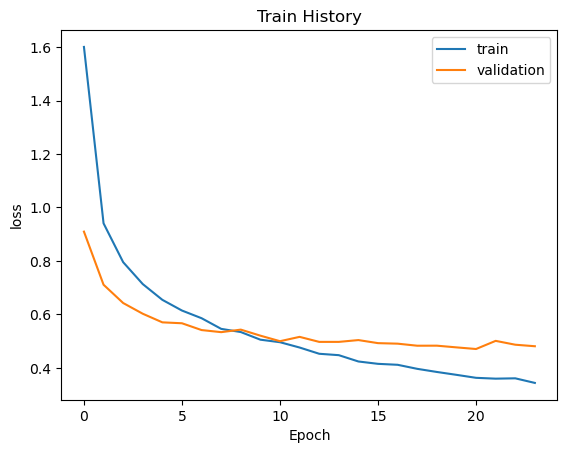

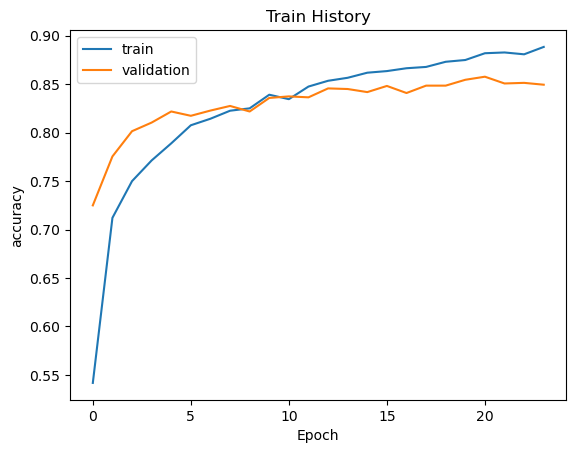

In [99]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### Xception model with updated code

In [11]:
def get_model():
    # Get base model 
    base_model = tf.keras.applications.Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    
    base_model_ouput = base_model.output
    
    # Add new layers
    x = layers.Rescaling(1./255)(base_model.output)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [12]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.1),
    # layers.RandomBrightness([-0.1,0.1])
]

train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [13]:
model = get_model()

print(f"target_size: {target_size}")
print(f"batch_size: {batch_size}")

# Learning Rate Optimizer
scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.90,
    staircase=True
)

optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

target_size: (150, 150)
batch_size: 64
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 74, 74, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 74, 74, 32)        

2024-01-18 11:25:46.189079: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-18 11:25:48.754259: I external/local_xla/xla/service/service.cc:168] XLA service 0x77ce89157410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-18 11:25:48.754309: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-01-18 11:25:48.770974: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705595148.883838   27831 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


197/197 [==============================] - ETA: 0s - loss: 2.3366 - accuracy: 0.4740

/home/brianpraetorius/miniconda3/envs/tf4/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


197/197 [==============================] - 91s 431ms/step - loss: 2.3366 - accuracy: 0.4740 - val_loss: 1.8445 - val_accuracy: 0.5661
Epoch 2/30
197/197 [==============================] - 83s 420ms/step - loss: 1.6830 - accuracy: 0.6036 - val_loss: 1.3751 - val_accuracy: 0.6569
Epoch 3/30
197/197 [==============================] - 83s 423ms/step - loss: 1.3735 - accuracy: 0.6483 - val_loss: 1.1417 - val_accuracy: 0.6954
Epoch 4/30
197/197 [==============================] - 84s 424ms/step - loss: 1.1952 - accuracy: 0.6739 - val_loss: 1.0162 - val_accuracy: 0.7112
Epoch 5/30
197/197 [==============================] - 83s 423ms/step - loss: 1.0824 - accuracy: 0.6971 - val_loss: 0.9322 - val_accuracy: 0.7287
Epoch 6/30
197/197 [==============================] - 83s 422ms/step - loss: 1.0131 - accuracy: 0.7073 - val_loss: 0.8721 - val_accuracy: 0.7462
Epoch 7/30
197/197 [==============================] - 83s 423ms/step - loss: 0.9579 - accuracy: 0.7195 - val_loss: 0.8363 - val_accuracy: 0.7

## DenseNet Models

### DenseNet121

#### First test with DenseNet121 image_size 150x150, batch=64 redo with proper preprocessing

In [88]:
def get_model():
    # Get base model 
    base_model = tf.keras.applications.DenseNet121(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = layers.Rescaling(1./255)(base_model.output)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [89]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.1),
    # layers.RandomBrightness([-0.1,0.1])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [90]:
# Get the model
model = get_model()
# Compile it

scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-4,
    decay_steps=1000,
    decay_rate=0.90,
    staircase=True
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#Summary
# model.summary()
checkpoint = keras.callbacks.ModelCheckpoint(
    'densenet121_v3_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/30
197/197 [==============================] - 90s 427ms/step - loss: 1.5364 - accuracy: 0.5953 - val_loss: 0.6717 - val_accuracy: 0.8072
Epoch 2/30
197/197 [==============================] - 82s 414ms/step - loss: 0.7241 - accuracy: 0.7833 - val_loss: 0.5250 - val_accuracy: 0.8351
Epoch 3/30
197/197 [==============================] - 81s 412ms/step - loss: 0.5697 - accuracy: 0.8235 - val_loss: 0.4046 - val_accuracy: 0.8745
Epoch 4/30
197/197 [==============================] - 81s 413ms/step - loss: 0.4963 - accuracy: 0.8428 - val_loss: 0.3784 - val_accuracy: 0.8767
Epoch 5/30
197/197 [==============================] - 81s 411ms/step - loss: 0.4490 - accuracy: 0.8584 - val_loss: 0.3509 - val_accuracy: 0.8885
Epoch 6/30
197/197 [==============================] - 81s 409ms/step - loss: 0.4039 - accuracy: 0.8732 - val_loss: 0.3512 - val_accuracy: 0.8799
Epoch 7/30
197/197 [==============================] - 80s 405ms/step - loss: 0.3877 - accuracy: 0.8765 - val_loss: 0.3434 - val_ac

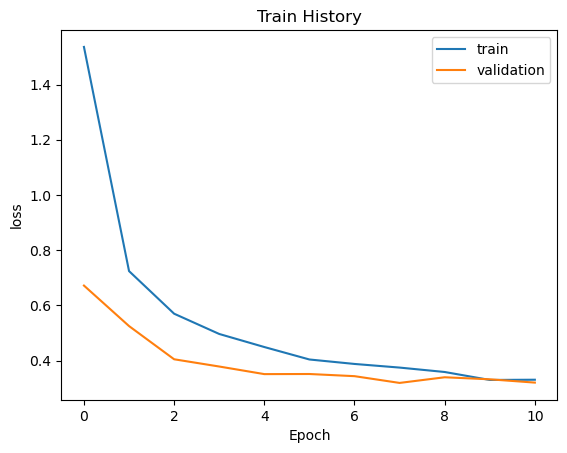

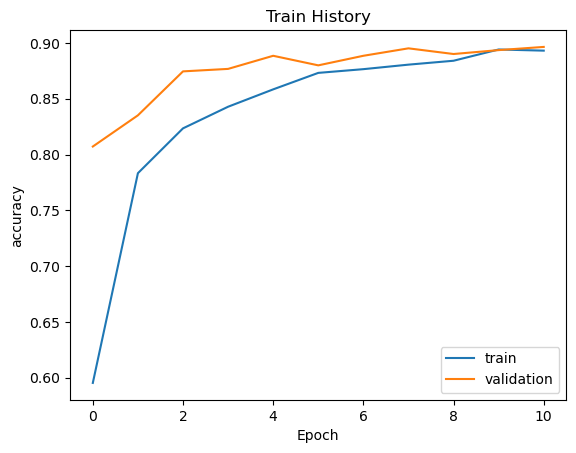

In [91]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

In [ ]:
#### DenseNet121 had significant performance improvements vs Xception/Inception and other layer modifications

#### Test 150x150 batch=64 densenet with proper preprocessing

In [84]:
def get_model():
    # Get base model 
    base_model = tf.keras.applications.DenseNet121(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = layers.Rescaling(1./255)(base_model.output)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [85]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.1),
    # layers.RandomBrightness([-0.1,0.1])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [86]:
# Get the model
model = get_model()
# Compile it

scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.90,
    staircase=True
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#Summary
# model.summary()
checkpoint = keras.callbacks.ModelCheckpoint(
    'densenet121_v2_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/30
197/197 [==============================] - 90s 419ms/step - loss: 2.3844 - accuracy: 0.4095 - val_loss: 1.7675 - val_accuracy: 0.5886
Epoch 2/30
197/197 [==============================] - 82s 415ms/step - loss: 1.5462 - accuracy: 0.6253 - val_loss: 1.0795 - val_accuracy: 0.7459
Epoch 3/30
197/197 [==============================] - 82s 414ms/step - loss: 1.1185 - accuracy: 0.7097 - val_loss: 0.7944 - val_accuracy: 0.7964
Epoch 4/30
197/197 [==============================] - 82s 415ms/step - loss: 0.9150 - accuracy: 0.7471 - val_loss: 0.6504 - val_accuracy: 0.8215
Epoch 5/30
197/197 [==============================] - 82s 414ms/step - loss: 0.7911 - accuracy: 0.7757 - val_loss: 0.5674 - val_accuracy: 0.8399
Epoch 6/30
197/197 [==============================] - 81s 412ms/step - loss: 0.7101 - accuracy: 0.7949 - val_loss: 0.5159 - val_accuracy: 0.8532
Epoch 7/30
197/197 [==============================] - 81s 413ms/step - loss: 0.6629 - accuracy: 0.8048 - val_loss: 0.4894 - val_ac

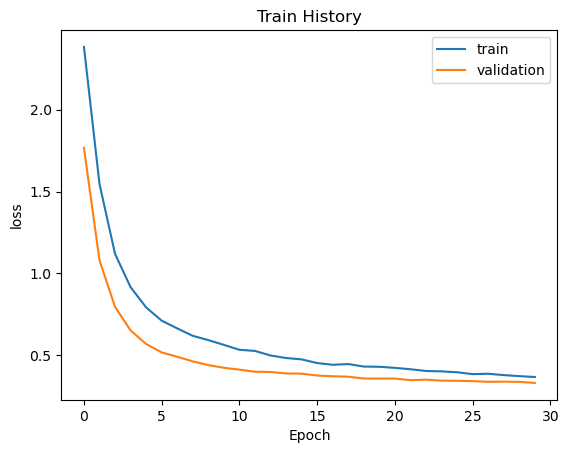

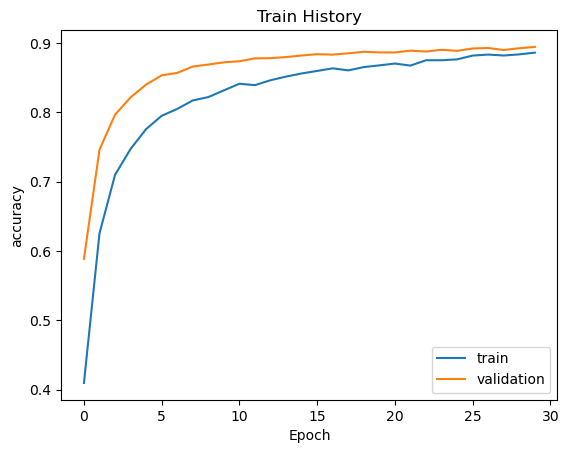

In [87]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### 150x150 Batch: 64 Drop Dense(128) layer

In [8]:
def get_model():
    # Get base model 
    base_model = tf.keras.applications.DenseNet121(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = layers.Rescaling(1./255)(base_model.output)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [9]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.1),
    # layers.RandomBrightness([-0.1,0.1])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [10]:
# Get the model
model = get_model()
# Compile it

scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.90,
    staircase=True
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#Summary
# model.summary()
checkpoint = keras.callbacks.ModelCheckpoint(
    'densenet121_v2_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/30


2024-01-17 11:51:06.062102: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-17 11:51:09.512361: I external/local_xla/xla/service/service.cc:168] XLA service 0x73dddcd1b2c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-17 11:51:09.512388: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-01-17 11:51:09.523983: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705510269.660563  137314 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


197/197 [==============================] - ETA: 0s - loss: 2.4455 - accuracy: 0.5129

/home/brianpraetorius/miniconda3/envs/tf4/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


197/197 [==============================] - 96s 441ms/step - loss: 2.4455 - accuracy: 0.5129 - val_loss: 1.9972 - val_accuracy: 0.6175
Epoch 2/30
197/197 [==============================] - 80s 408ms/step - loss: 1.8022 - accuracy: 0.6729 - val_loss: 1.4076 - val_accuracy: 0.7325
Epoch 3/30
197/197 [==============================] - 81s 409ms/step - loss: 1.3797 - accuracy: 0.7274 - val_loss: 1.0685 - val_accuracy: 0.7770
Epoch 4/30
197/197 [==============================] - 81s 409ms/step - loss: 1.1240 - accuracy: 0.7557 - val_loss: 0.8755 - val_accuracy: 0.7948
Epoch 5/30
197/197 [==============================] - 81s 410ms/step - loss: 0.9632 - accuracy: 0.7727 - val_loss: 0.7507 - val_accuracy: 0.8135
Epoch 6/30
197/197 [==============================] - 81s 408ms/step - loss: 0.8555 - accuracy: 0.7892 - val_loss: 0.6745 - val_accuracy: 0.8253
Epoch 7/30
197/197 [==============================] - 81s 410ms/step - loss: 0.7843 - accuracy: 0.7983 - val_loss: 0.6193 - val_accuracy: 0.8

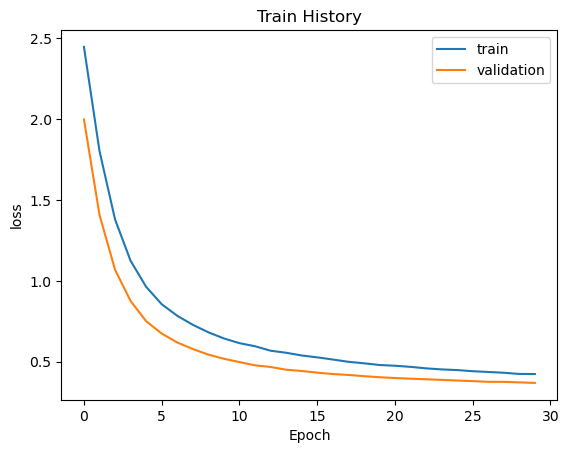

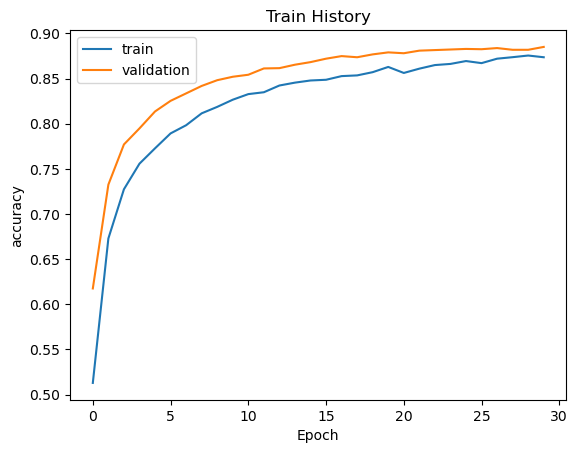

In [12]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### Test Modified Code

In [10]:
def get_model():
    # Get base model 
    base_model = tf.keras.applications.DenseNet121(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    
    base_model_ouput = base_model.output
    
    # Add new layers
    x = layers.Rescaling(1./255)(base_model.output)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [11]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.1),
    # layers.RandomBrightness([-0.1,0.1])
]

train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [12]:
model = get_model()

print(f"target_size: {target_size}")
print(f"batch_size: {batch_size}")

# Learning Rate Optimizer
scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.90,
    staircase=True
)

optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

checkpoint = keras.callbacks.ModelCheckpoint(
    'densenet121_v3_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

target_size: (150, 150)
batch_size: 64
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 156, 156, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 75, 75, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 75, 75, 64)        

2024-01-17 16:46:38.917974: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-17 16:46:42.449610: I external/local_xla/xla/service/service.cc:168] XLA service 0x7bd489161a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-17 16:46:42.449662: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-01-17 16:46:42.466703: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705528002.606500  178480 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


197/197 [==============================] - ETA: 0s - loss: 2.4511 - accuracy: 0.5072

/home/brianpraetorius/miniconda3/envs/tf4/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


197/197 [==============================] - 96s 439ms/step - loss: 2.4511 - accuracy: 0.5072 - val_loss: 2.0026 - val_accuracy: 0.6233
Epoch 2/30
197/197 [==============================] - 81s 409ms/step - loss: 1.8071 - accuracy: 0.6716 - val_loss: 1.4116 - val_accuracy: 0.7376
Epoch 3/30
197/197 [==============================] - 81s 411ms/step - loss: 1.3846 - accuracy: 0.7206 - val_loss: 1.0709 - val_accuracy: 0.7773
Epoch 4/30
197/197 [==============================] - 80s 407ms/step - loss: 1.1265 - accuracy: 0.7566 - val_loss: 0.8754 - val_accuracy: 0.7945
Epoch 5/30
197/197 [==============================] - 81s 412ms/step - loss: 0.9644 - accuracy: 0.7772 - val_loss: 0.7522 - val_accuracy: 0.8116
Epoch 6/30
197/197 [==============================] - 81s 410ms/step - loss: 0.8616 - accuracy: 0.7920 - val_loss: 0.6753 - val_accuracy: 0.8262
Epoch 7/30
197/197 [==============================] - 81s 410ms/step - loss: 0.7883 - accuracy: 0.8008 - val_loss: 0.6196 - val_accuracy: 0.8

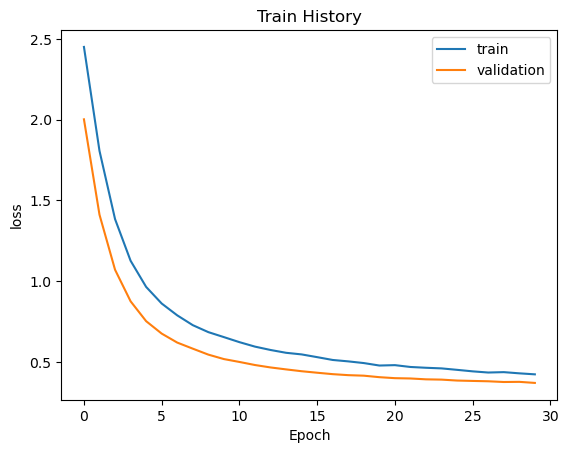

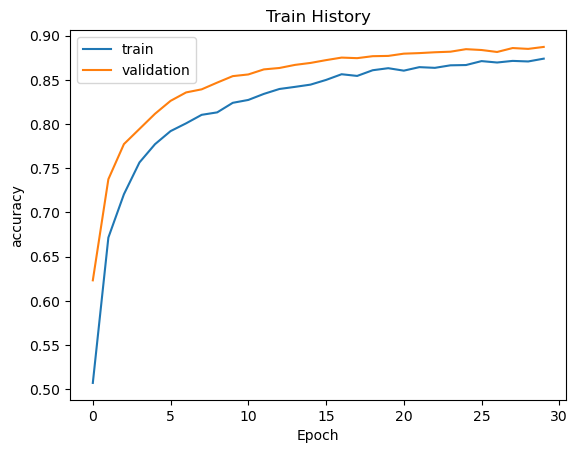

In [13]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

### DenseNet169

#### First Try

In [80]:
def get_model():
    # Get base model 
    base_model = tf.keras.applications.DenseNet169(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = layers.Rescaling(1./255)(base_model.output)
    x = layers.Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [81]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.1),
    # layers.RandomBrightness([-0.1,0.1])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [82]:
# Get the model
model = get_model()
# Compile it

scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.90,
    staircase=True
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#Summary
# model.summary()
checkpoint = keras.callbacks.ModelCheckpoint(
    'densenet169_v2_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/30
197/197 [==============================] - 95s 441ms/step - loss: 2.3044 - accuracy: 0.4521 - val_loss: 1.6135 - val_accuracy: 0.6169
Epoch 2/30
197/197 [==============================] - 84s 427ms/step - loss: 1.4051 - accuracy: 0.6590 - val_loss: 0.9501 - val_accuracy: 0.7687
Epoch 3/30
197/197 [==============================] - 84s 428ms/step - loss: 0.9990 - accuracy: 0.7396 - val_loss: 0.6967 - val_accuracy: 0.8205
Epoch 4/30
197/197 [==============================] - 84s 428ms/step - loss: 0.8135 - accuracy: 0.7737 - val_loss: 0.5838 - val_accuracy: 0.8428
Epoch 5/30
197/197 [==============================] - 84s 428ms/step - loss: 0.7097 - accuracy: 0.7999 - val_loss: 0.5102 - val_accuracy: 0.8593
Epoch 6/30
197/197 [==============================] - 85s 432ms/step - loss: 0.6377 - accuracy: 0.8193 - val_loss: 0.4622 - val_accuracy: 0.8720
Epoch 7/30
197/197 [==============================] - 84s 427ms/step - loss: 0.5933 - accuracy: 0.8251 - val_loss: 0.4402 - val_ac

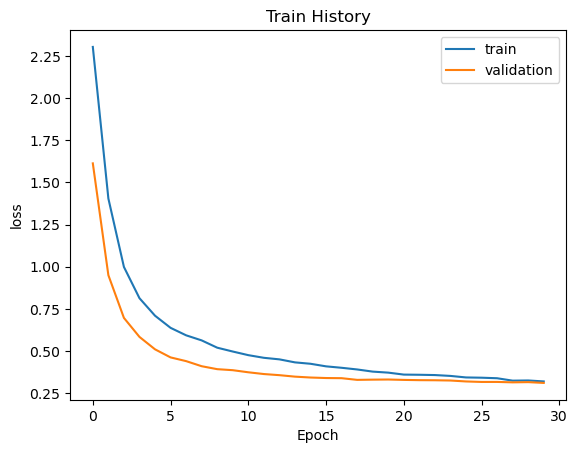

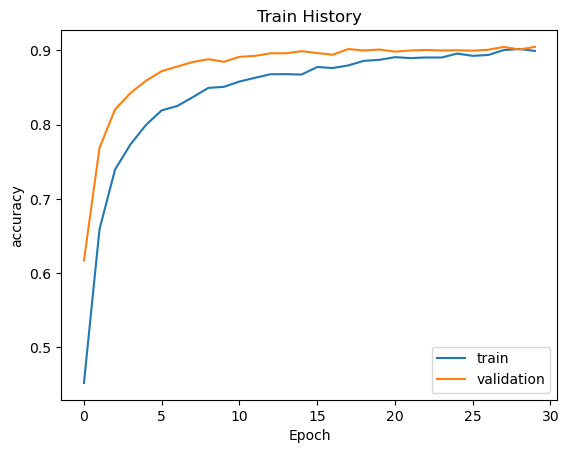

In [83]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### Same as above, with faster training rate

In [70]:
# Get the model
model = get_model()
# Compile it

scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.90,
    staircase=True
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#Summary
# model.summary()
checkpoint = keras.callbacks.ModelCheckpoint(
    'densenet169_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/30
197/197 [==============================] - 89s 419ms/step - loss: 1.3182 - accuracy: 0.6487 - val_loss: 0.5653 - val_accuracy: 0.8358
Epoch 2/30
197/197 [==============================] - 80s 408ms/step - loss: 0.6468 - accuracy: 0.8030 - val_loss: 0.5059 - val_accuracy: 0.8428
Epoch 3/30
197/197 [==============================] - 81s 413ms/step - loss: 0.5281 - accuracy: 0.8367 - val_loss: 0.4623 - val_accuracy: 0.8685
Epoch 4/30
197/197 [==============================] - 79s 403ms/step - loss: 0.4419 - accuracy: 0.8602 - val_loss: 0.4756 - val_accuracy: 0.8520
Epoch 5/30
197/197 [==============================] - 81s 412ms/step - loss: 0.4101 - accuracy: 0.8691 - val_loss: 0.4041 - val_accuracy: 0.8841
Epoch 6/30
197/197 [==============================] - 79s 401ms/step - loss: 0.3498 - accuracy: 0.8880 - val_loss: 0.3951 - val_accuracy: 0.8787
Epoch 7/30
197/197 [==============================] - 81s 411ms/step - loss: 0.3265 - accuracy: 0.8971 - val_loss: 0.3890 - val_ac

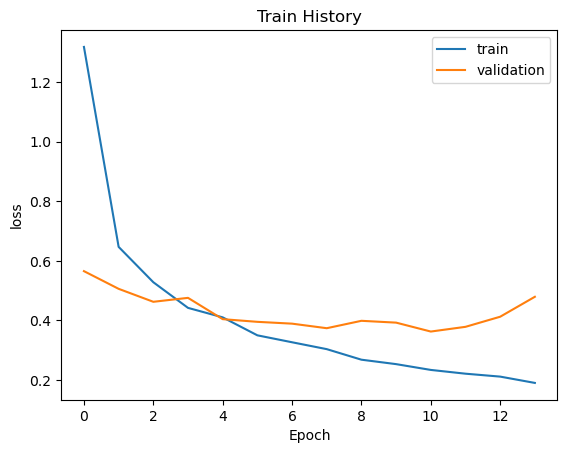

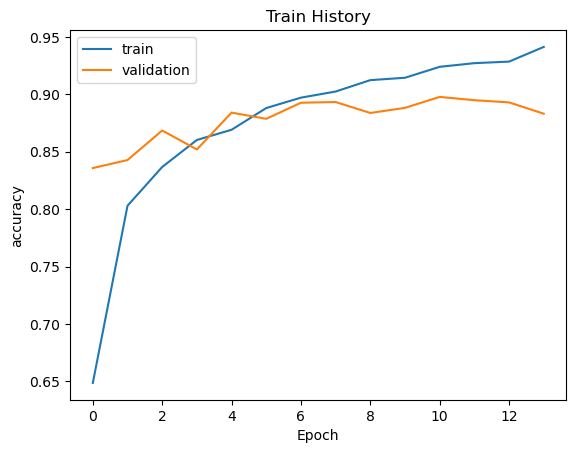

In [71]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

### DenseNet201

#### First Test

In [76]:
def get_model():
    # Get base model 
    base_model = tf.keras.applications.DenseNet201(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = layers.Rescaling(1./255)(base_model.output)
    x = layers.Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [77]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.1),
    # layers.RandomBrightness([-0.1,0.1])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [78]:
# Get the model
model = get_model()
# Compile it

scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.90,
    staircase=True
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint(
    'densenet201_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

74836368/74836368 [==============================] - 2s 0us/step
Epoch 1/30
197/197 [==============================] - 103s 470ms/step - loss: 2.3249 - accuracy: 0.4518 - val_loss: 1.6367 - val_accuracy: 0.6769
Epoch 2/30
197/197 [==============================] - 88s 445ms/step - loss: 1.4200 - accuracy: 0.6638 - val_loss: 0.9532 - val_accuracy: 0.7865
Epoch 3/30
197/197 [==============================] - 89s 449ms/step - loss: 1.0046 - accuracy: 0.7381 - val_loss: 0.6783 - val_accuracy: 0.8374
Epoch 4/30
197/197 [==============================] - 88s 446ms/step - loss: 0.8061 - accuracy: 0.7793 - val_loss: 0.5473 - val_accuracy: 0.8621
Epoch 5/30
197/197 [==============================] - 88s 446ms/step - loss: 0.6851 - accuracy: 0.8040 - val_loss: 0.4772 - val_accuracy: 0.8745
Epoch 6/30
197/197 [==============================] - 88s 446ms/step - loss: 0.6162 - accuracy: 0.8209 - val_loss: 0.4314 - val_accuracy: 0.8856
Epoch 7/30
197/197 [==============================] - 88s 447ms/

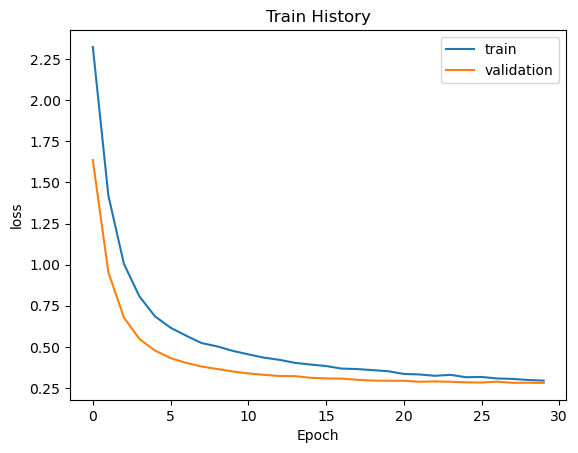

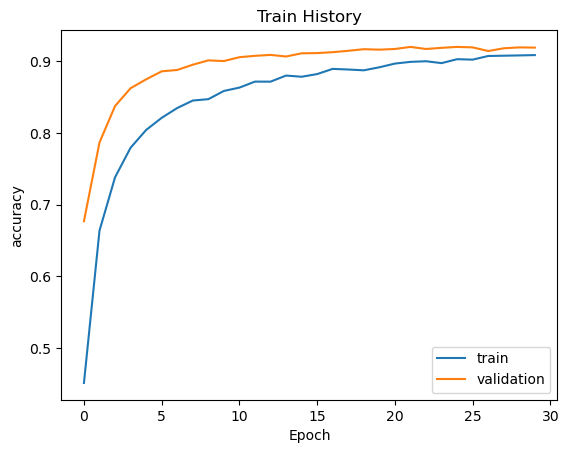

In [79]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### Export model as .h5

In [9]:
def get_model():
    # Get base model 
    base_model = tf.keras.applications.DenseNet201(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    
    base_model_ouput = base_model.output
    
    # Add new layers
    x = layers.Rescaling(1./255)(base_model.output)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [13]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
]

train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [14]:
model = get_model()

print(f"target_size: {target_size}")
print(f"batch_size: {batch_size}")

# Learning Rate Optimizer
scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.90,
    staircase=True
)

optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

checkpoint = keras.callbacks.ModelCheckpoint(
    'densenet201_v2_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

target_size: (150, 150)
batch_size: 64
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 156, 156, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 75, 75, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 75, 75, 64)        

2024-01-17 19:01:22.870580: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-17 19:01:27.995428: I external/local_xla/xla/service/service.cc:168] XLA service 0x7e76fcfd8df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-17 19:01:27.995462: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-01-17 19:01:28.006497: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705536088.137753  200559 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


197/197 [==============================] - ETA: 0s - loss: 2.3848 - accuracy: 0.5561

/home/brianpraetorius/miniconda3/envs/tf4/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


197/197 [==============================] - 112s 493ms/step - loss: 2.3848 - accuracy: 0.5561 - val_loss: 1.8669 - val_accuracy: 0.6830
Epoch 2/30
197/197 [==============================] - 86s 438ms/step - loss: 1.6623 - accuracy: 0.7086 - val_loss: 1.2534 - val_accuracy: 0.7719
Epoch 3/30
197/197 [==============================] - 87s 443ms/step - loss: 1.2273 - accuracy: 0.7571 - val_loss: 0.9267 - val_accuracy: 0.8208
Epoch 4/30
197/197 [==============================] - 87s 442ms/step - loss: 0.9848 - accuracy: 0.7884 - val_loss: 0.7486 - val_accuracy: 0.8405
Epoch 5/30
197/197 [==============================] - 88s 445ms/step - loss: 0.8313 - accuracy: 0.8122 - val_loss: 0.6338 - val_accuracy: 0.8545
Epoch 6/30
197/197 [==============================] - 87s 441ms/step - loss: 0.7394 - accuracy: 0.8204 - val_loss: 0.5689 - val_accuracy: 0.8618
Epoch 7/30
197/197 [==============================] - 86s 437ms/step - loss: 0.6750 - accuracy: 0.8307 - val_loss: 0.5193 - val_accuracy: 0.

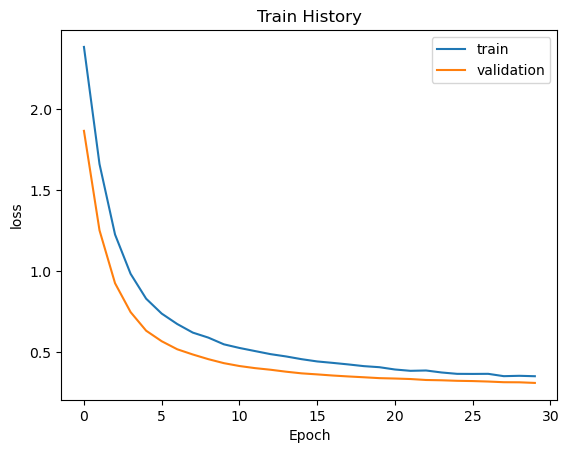

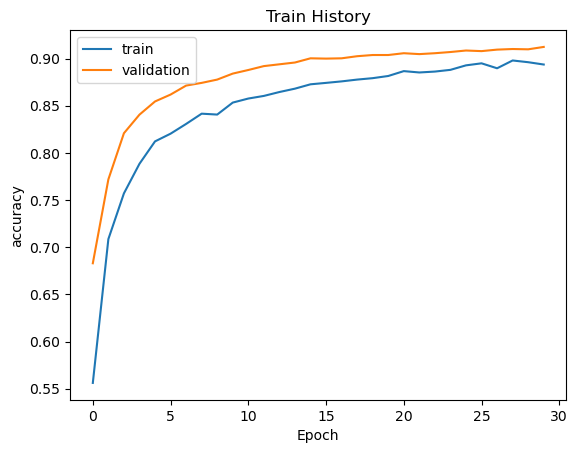

In [15]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### Bigger Tree

In [17]:
def get_model():
    # Get base model 
    base_model = tf.keras.applications.DenseNet201(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    
    base_model_ouput = base_model.output
    
    # Add new layers
    x = layers.Rescaling(1./255)(base_model.output)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [18]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
]

train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [19]:
model = get_model()

print(f"target_size: {target_size}")
print(f"batch_size: {batch_size}")

# Learning Rate Optimizer
scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.90,
    staircase=True
)

optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

checkpoint = keras.callbacks.ModelCheckpoint(
    'densenet201_v3_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

target_size: (150, 150)
batch_size: 64
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 156, 156, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 75, 75, 64)           9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 75, 75, 64)      

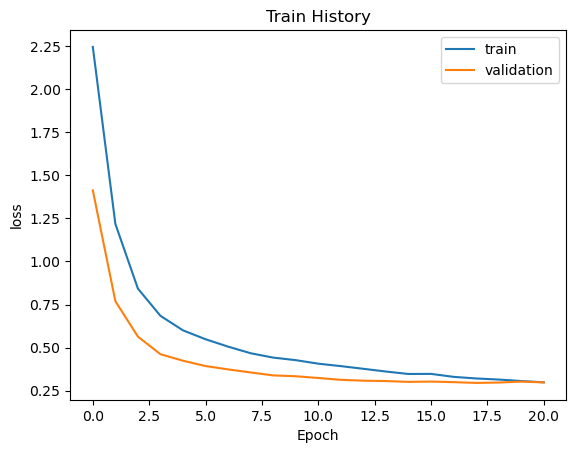

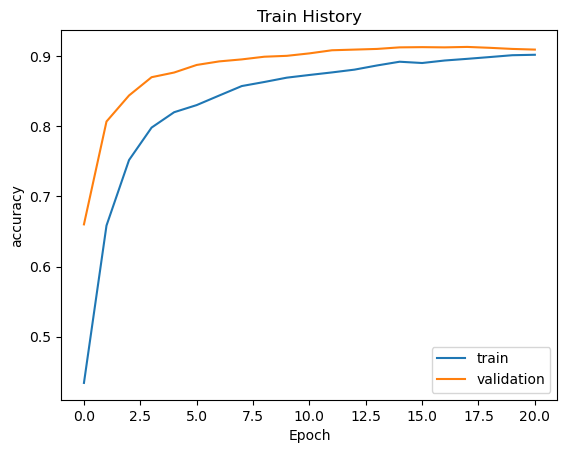

In [20]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

## InceptionV3

#### 150x150 with batch=64

In [108]:
def get_model():
    # Get base model 
    base_model = InceptionV3(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = layers.Rescaling(1./255)(base_model.output)
    x = layers.Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [109]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.2),
    # layers.RandomBrightness([-0.2,0.2])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [110]:
# Get the model
model = get_model()
# Compile it

scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#Summary
# model.summary()
checkpoint = keras.callbacks.ModelCheckpoint(
    'inceptionv3_v4_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/30
197/197 [==============================] - 89s 418ms/step - loss: 2.3552 - accuracy: 0.2858 - val_loss: 1.8740 - val_accuracy: 0.4546
Epoch 2/30
197/197 [==============================] - 78s 395ms/step - loss: 1.7059 - accuracy: 0.5385 - val_loss: 1.3732 - val_accuracy: 0.6585
Epoch 3/30
197/197 [==============================] - 77s 391ms/step - loss: 1.3820 - accuracy: 0.6125 - val_loss: 1.1257 - val_accuracy: 0.7106
Epoch 4/30
197/197 [==============================] - 78s 394ms/step - loss: 1.2054 - accuracy: 0.6544 - val_loss: 0.9963 - val_accuracy: 0.7259
Epoch 5/30
197/197 [==============================] - 80s 404ms/step - loss: 1.0958 - accuracy: 0.6811 - val_loss: 0.9076 - val_accuracy: 0.7503
Epoch 6/30
197/197 [==============================] - 80s 404ms/step - loss: 1.0118 - accuracy: 0.7010 - val_loss: 0.8437 - val_accuracy: 0.7681
Epoch 7/30
197/197 [==============================] - 80s 405ms/step - loss: 0.9581 - accuracy: 0.7116 - val_loss: 0.7989 - val_ac

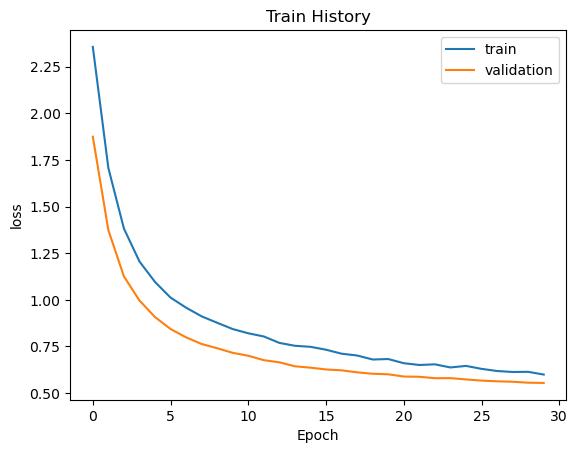

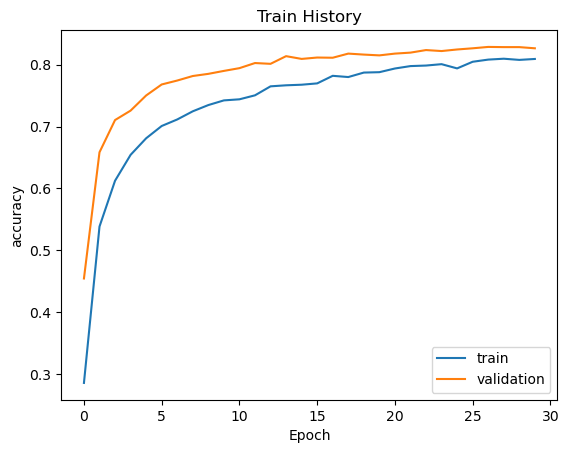

In [111]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### Inception model with 150x150 batch=64

In [111]:
def get_model():
    # Get base model 
    base_model = InceptionV3(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = Rescaling(1./255)
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [112]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.2),
    # layers.RandomBrightness([-0.2,0.2])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [113]:
# Get the model
model = get_model()
# Compile it

scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=scheduler, weight_decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#Summary
# model.summary()
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=30, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/30
197/197 [==============================] - 89s 422ms/step - loss: 1.5355 - accuracy: 0.5796 - val_loss: 1.0331 - val_accuracy: 0.6795
Epoch 2/30
197/197 [==============================] - 80s 404ms/step - loss: 0.9568 - accuracy: 0.7055 - val_loss: 0.7801 - val_accuracy: 0.7611
Epoch 3/30
197/197 [==============================] - 80s 405ms/step - loss: 0.7961 - accuracy: 0.7524 - val_loss: 0.8019 - val_accuracy: 0.7678
Epoch 4/30
197/197 [==============================] - 79s 403ms/step - loss: 0.7308 - accuracy: 0.7716 - val_loss: 0.6405 - val_accuracy: 0.8081
Epoch 5/30
197/197 [==============================] - 79s 399ms/step - loss: 0.6889 - accuracy: 0.7834 - val_loss: 0.7175 - val_accuracy: 0.7795
Epoch 6/30
197/197 [==============================] - 80s 406ms/step - loss: 0.6230 - accuracy: 0.8034 - val_loss: 0.6238 - val_accuracy: 0.8145
Epoch 7/30
197/197 [==============================] - 79s 402ms/step - loss: 0.5999 - accuracy: 0.8148 - val_loss: 0.5834 - val_ac

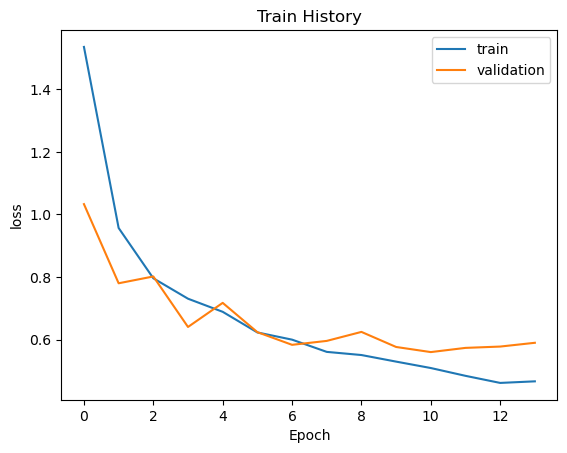

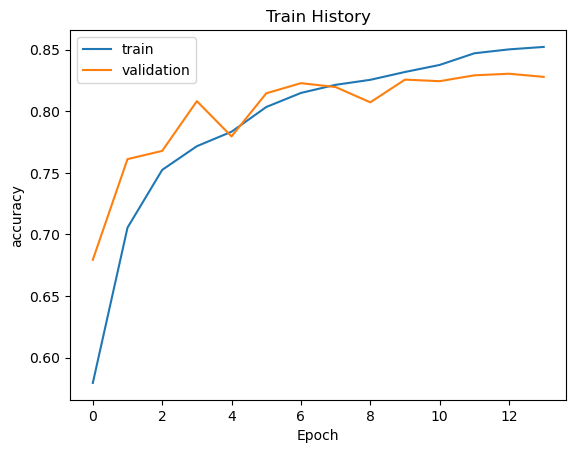

In [114]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### More

In [42]:
def get_model_inception():
    # Get base model 
    base_model = InceptionV3(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output
    
    # Add new layers
    x = Rescaling(1./255)
    x = Flatten()(base_model.output)
    x = Dense(500, activation='relu', name='fc1')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='softmax', name='fc2')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [43]:
# Get the model
model = get_model_inception()
# Compile it
opt = Adam(learning_rate=1e-3, weight_decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
#Summary
# model.summary()
checkpoint = keras.callbacks.ModelCheckpoint(
    'inv_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history_fine=model.fit(train_ds, epochs=20, verbose=1, validation_data=val_ds, callbacks=[checkpoint,early_stopping])

Epoch 1/20
197/197 [==============================] - 17s 56ms/step - loss: 2.1534 - accuracy: 0.5635 - val_loss: 0.9601 - val_accuracy: 0.7062
Epoch 2/20
 55/197 [=======>......................] - ETA: 3s - loss: 0.9439 - accuracy: 0.7068

KeyboardInterrupt: 

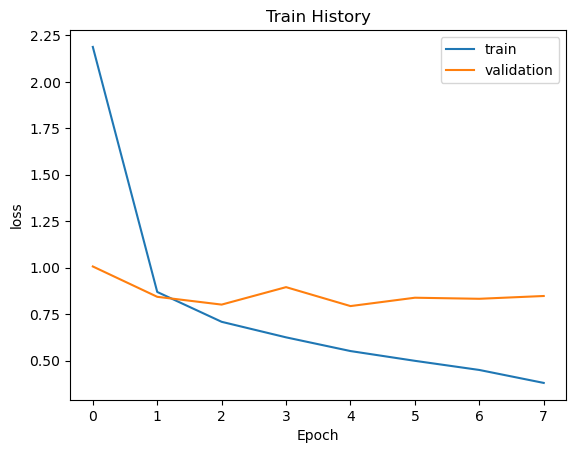

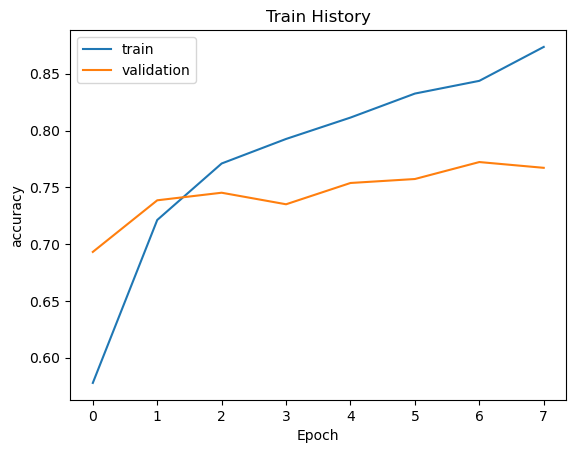

In [43]:
show_train_history(history_fine,'loss','val_loss')
show_train_history(history_fine,'accuracy','val_accuracy')

#### 256x256 32

In [61]:
def get_model():
    # Get base model 
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape)
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
    # Get base model output 
    base_model_ouput = base_model.output

    # Preprocess
    inputs = Input(input_shape)
    x = Rescaling(1./255)(inputs)
    
    # Add new layers
    
    # x = Dense(16, activation='relu')(x)
    # x = Dense(64, activation='relu')(x)
    # x = Dense(256, activation='relu')(x)
    x = Dense(500, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Flatten()(base_model.output)
    x = Dense(16, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [62]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.2),
    # layers.RandomBrightness([-0.2,0.2])
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [63]:
# Get the model
model = get_model()


optimizer = Adam(learning_rate=1e-3, weight_decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#Summary
# model.summary()
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v2_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history_fine=model.fit(train_ds_aug, epochs=20, verbose=1, validation_data=val_ds, callbacks=[checkpoint, early_stopping])

Epoch 1/20
394/394 [==============================] - 83s 204ms/step - loss: 1.9745 - accuracy: 0.6152 - val_loss: 1.6617 - val_accuracy: 0.7205
Epoch 2/20
394/394 [==============================] - 80s 202ms/step - loss: 1.6700 - accuracy: 0.6994 - val_loss: 1.8713 - val_accuracy: 0.7322
Epoch 3/20
394/394 [==============================] - 79s 201ms/step - loss: 1.7054 - accuracy: 0.7216 - val_loss: 1.4936 - val_accuracy: 0.7786
Epoch 4/20
394/394 [==============================] - 79s 200ms/step - loss: 1.6143 - accuracy: 0.7367 - val_loss: 2.0718 - val_accuracy: 0.7246
Epoch 5/20
394/394 [==============================] - 78s 199ms/step - loss: 1.5925 - accuracy: 0.7541 - val_loss: 1.7959 - val_accuracy: 0.7722
Epoch 6/20
394/394 [==============================] - 79s 200ms/step - loss: 1.5655 - accuracy: 0.7590 - val_loss: 1.8397 - val_accuracy: 0.7713
